# Introduction

## Context

## Summary

# Data Preparation
## Modules, Functions Import & Configuration

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
import warnings
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score, precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

from helper_functions import get_screen_width, get_color_palette, set_font_size
from helper_functions import draw_numerical_plots, draw_categorical_plots, draw_predictor_target_plots, draw_boxplots, correlation_matrices
from helper_functions import t_test, chi_squared_test, visualize_performance, benchmark_models, draw_original_log_distribution
from helper_functions import bmi_category, age_group, glucose_category, lifestyle_score, work_stress_proxy

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
RANDOM_STATE = 98
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option('display.max_colwidth', None)
HTML('<style>{}</style>'.format(open('styles.css').read()))

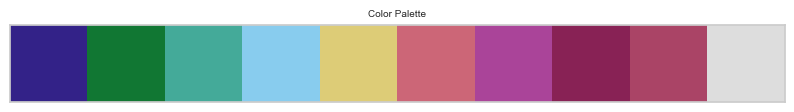

In [4]:
color_palette = get_color_palette()
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style('whitegrid', {'axes.grid' : False})
sns.palplot(color_palette)
plt.title('Color Palette')
plt.show()

## Dataset Import

In [5]:
DATA_PATH = 'data'
CSV_NAME = 'healthcare-dataset-stroke-data.csv'
ZIP_NAME = 'stroke-prediction-dataset.zip'

#!kaggle datasets download -d fedesoriano/stroke-prediction-dataset -p {DATA_PATH}
#with zipfile.ZipFile(os.path.join(DATA_PATH, ZIP_NAME), 'r') as zip_ref:
#    zip_ref.extractall(DATA_PATH)
#os.remove(os.path.join(DATA_PATH, ZIP_NAME))

df = pd.read_csv(os.path.join(DATA_PATH, CSV_NAME))

In [6]:
df = pd.read_csv(DATA_PATH+'/'+CSV_NAME)
df.head().T

,0,1,2,3,4
id,9046,51676,31112,60182,1665
gender,Male,Female,Male,Female,Female
age,67.0,61.0,80.0,49.0,79.0
hypertension,0,0,0,0,1
heart_disease,1,0,1,0,0
ever_married,Yes,Yes,Yes,Yes,Yes
work_type,Private,Self-employed,Private,Private,Self-employed
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,228.69,202.21,105.92,171.23,174.12
bmi,36.6,NaN,32.5,34.4,24.0


In [7]:
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset size: 5110 rows, 12 columns


# Data Formatting & Cleaning

In [8]:
df.columns = df.columns.str.lower()
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)

In [9]:
def get_unique_values_summary(df):
    summary = []
    for col in df.columns:
        if df[col].dtype == 'object':
            unique_values = df[col].unique()
            summary.append({
                'Column': col,
                'Unique Values Count': len(unique_values),
                'Unique Values': unique_values
            })
    return pd.DataFrame(summary)


get_unique_values_summary(df)

,Column,Unique Values Count,Unique Values
0,gender,3,"[Male, Female, Other]"
1,ever_married,2,"[Yes, No]"
2,work_type,5,"[Private, Self-employed, Govt_job, children, Never_worked]"
3,residence_type,2,"[Urban, Rural]"
4,smoking_status,4,"[formerly smoked, never smoked, smokes, Unknown]"


In [10]:
duplicate_count = df.duplicated().sum()
print(f"Total rows: {len(df)}")
print(f"Duplicate rows: {duplicate_count}")
duplicates = df[df.duplicated(keep=False)]
sorted_duplicates = duplicates.sort_values(by=list(df.columns))
sorted_duplicates[:10] if len(duplicates) > 0 else None

Total rows: 5110
Duplicate rows: 0


## Data Summary & Distribution
### Numerical Data

In [11]:
numeric_cols = df.drop('id', axis=1).select_dtypes(exclude='object').columns

In [12]:
round(df[numeric_cols].describe(exclude='object'), 2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00


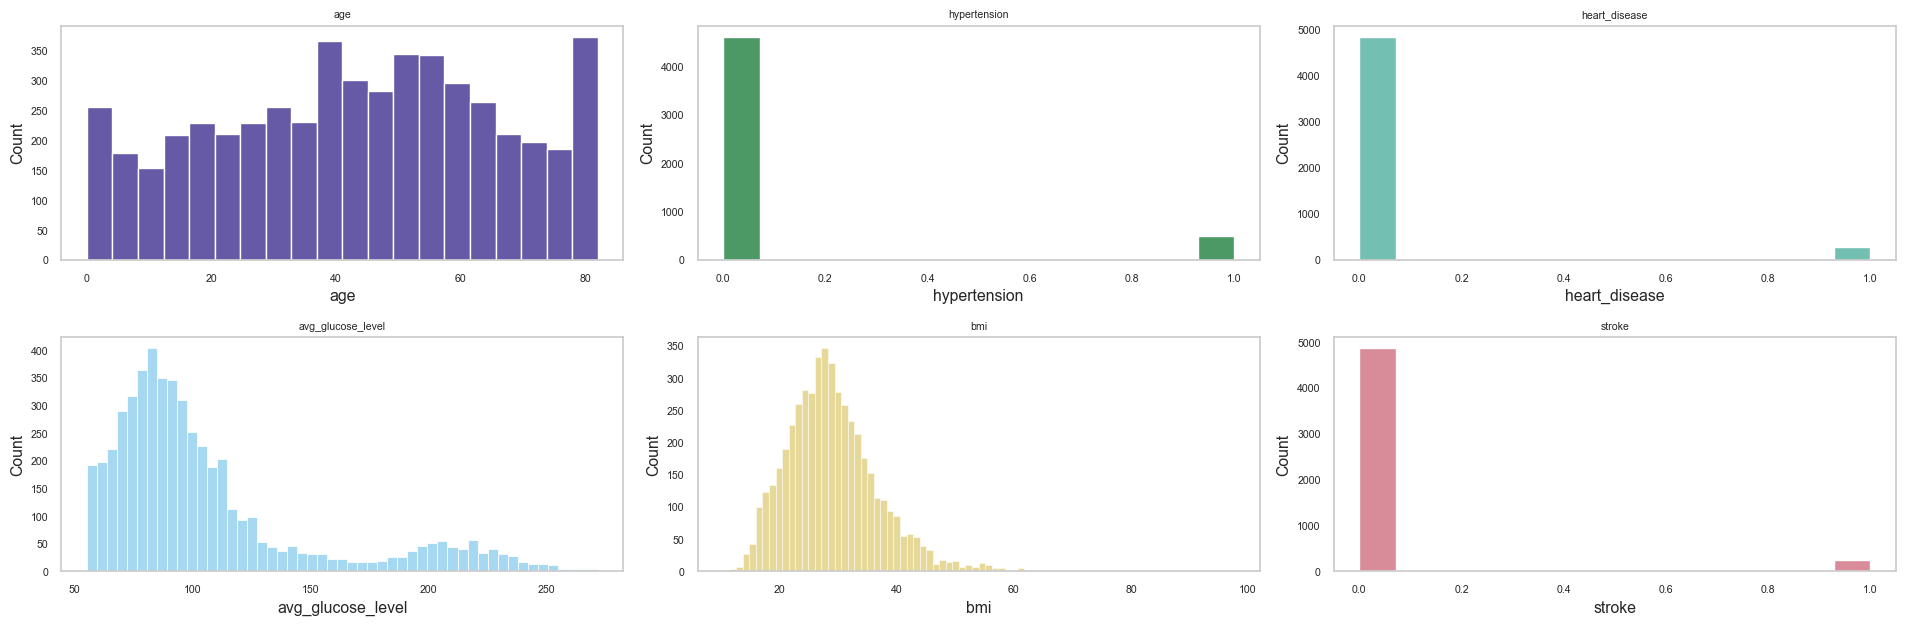

In [13]:
draw_numerical_plots(df, cols_list=numeric_cols, grid_cols=3)

## Categorical Data

In [14]:
categorical_cols = df.select_dtypes(include='object').columns

In [15]:
round(df.describe(include=['object']), 2)

,gender,ever_married,work_type,residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


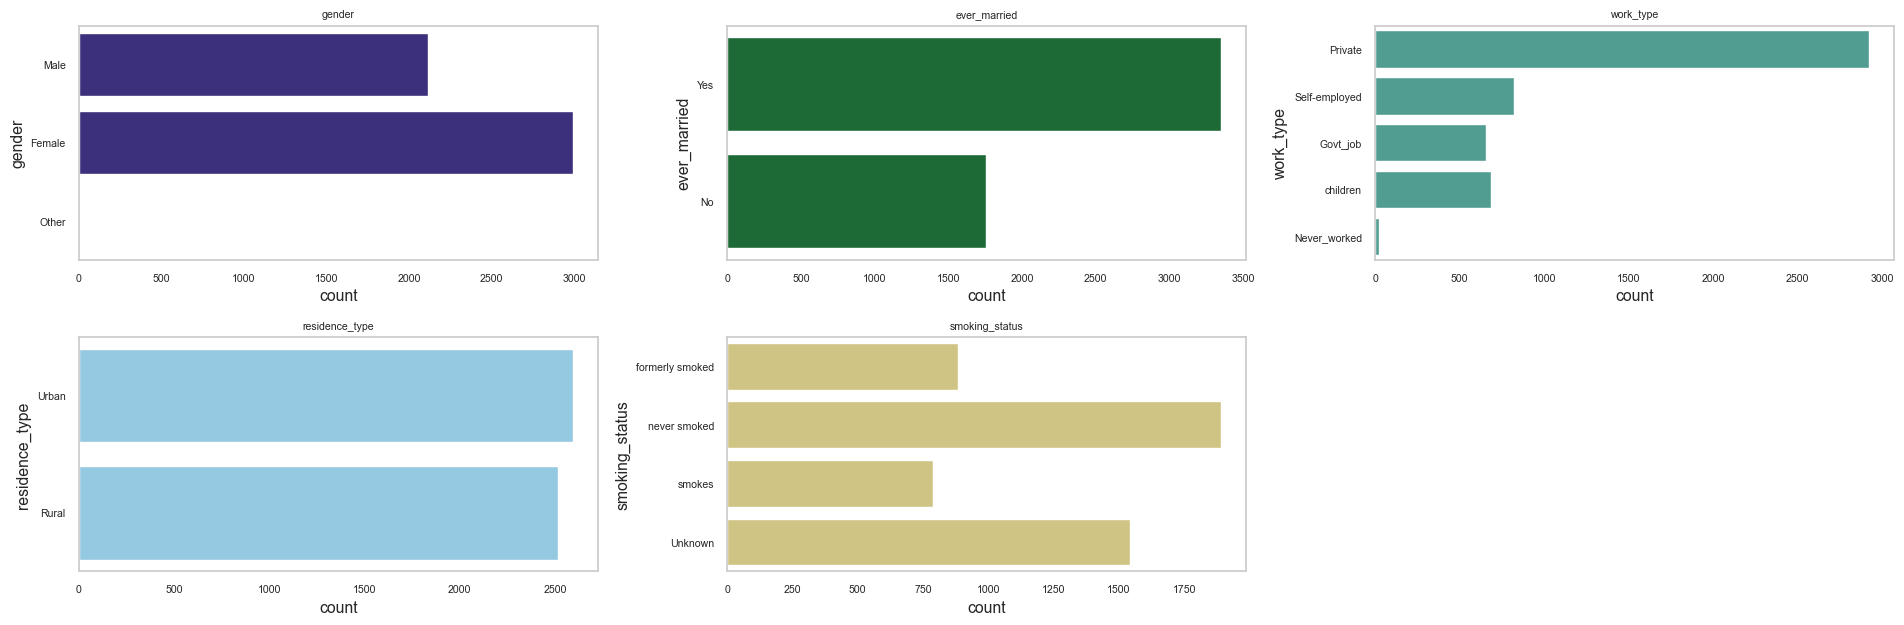

In [16]:
draw_categorical_plots(df, cols_list=categorical_cols, grid_cols=3)

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <li>Medium-sized dataset of ~5000 rows, no duplicate values</li>
        <li>Data types match the contents as seen in <code>df.head()</code></li>
        <li>Imputation required for the <code>bmi</code> column as it has `null` values</li>
        <li>Mixed column data types (7 numeric, 5 categorical)</li>
        <li>3 numeric variables are binary</li>
        <li><code>avg_glucose_level</code> and <code>bmi</code> have outliers; both are right-skewed</li>
        <li>Categorical columns don't have high cardinality; only two categories are outliers</li>
    </ol>
</div>

# Exploratory Data Analysis
For some statistical significance & correlation tests, we will need a complete dataset without any missing values. We will impute the mean / most frequent value for numeric and categorical values respectively. In our case, only `bmi` will require imputing.

In [17]:
df_imputed = df.copy()
df_imputed[numeric_cols] = SimpleImputer(strategy='mean').fit_transform(df[numeric_cols])
df_imputed[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])

## Target variable

In [18]:
value_counts = df['stroke'].value_counts()
percentage_of_total = round((value_counts / value_counts.sum()) * 100, 2)
result = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total (%)': percentage_of_total
})
result

,Value Counts,Percentage of Total (%)
stroke,,
0,4861,95.13
1,249,4.87


Less than 5% of the subjects in the dataset had a stroke. We will experiment with class weights during model training.

## Numerical predictors
### Age

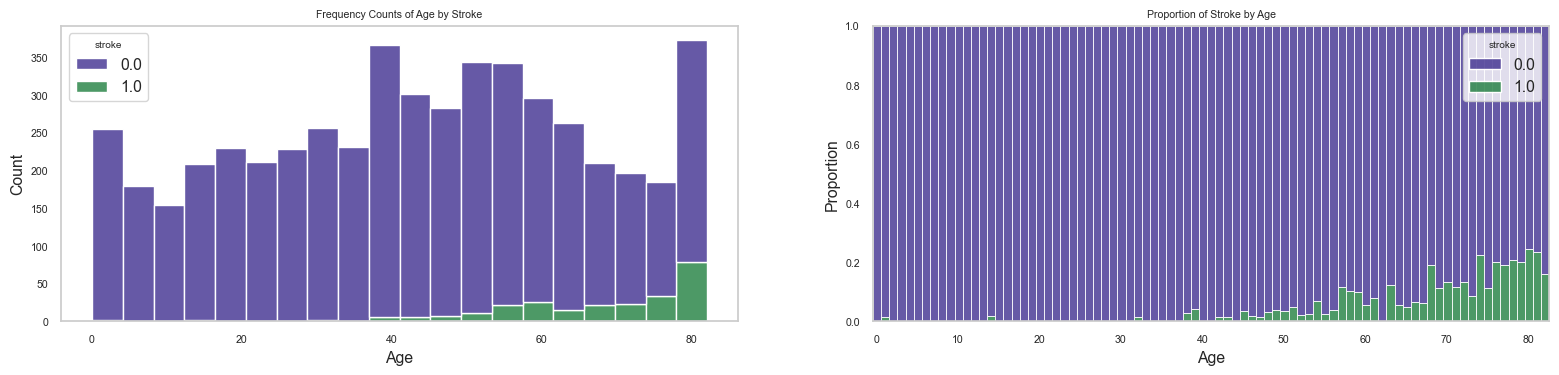

T-statistic: 18.08
P-value: 0.000000
Mean age of stroke group: 67.73
Mean age of non-stroke group: 41.97


In [19]:
draw_predictor_target_plots(df_imputed, predictor='age', target='stroke')
t_test(df_imputed, predictor='age', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Age and Stroke</p>
    <ol>
        <li>Strokes were more frequent at older age, ramping up from 40 years old</li>
        <li>From around age 75, about 20% of patients in the dataset suffered from a stroke</li>
        <li>There is a statistically significant difference in age between stroke and non-stroke patients</li>
    </ol>
</div>

### Body Mass Index (BMI)

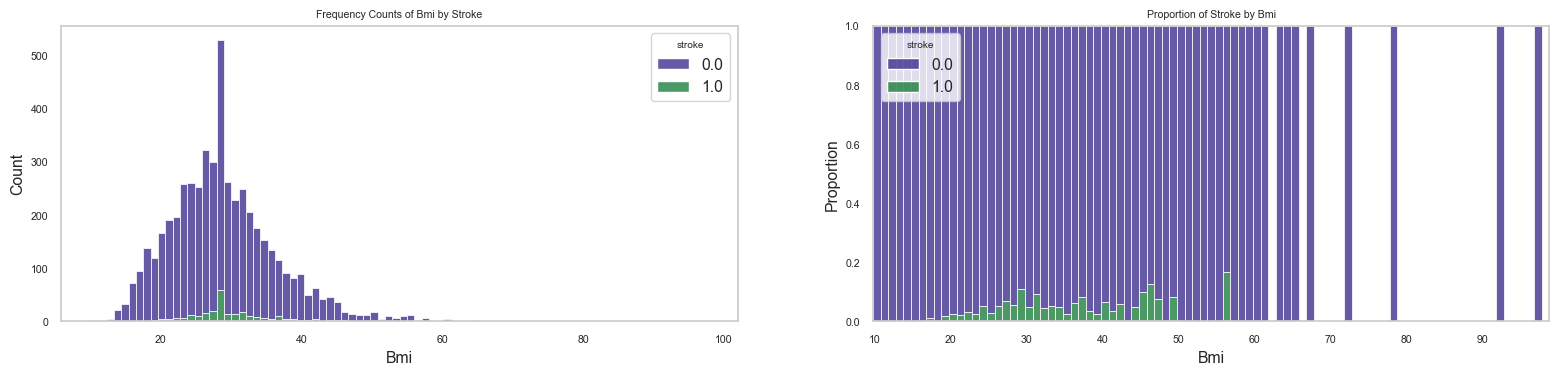

T-statistic: 2.79
P-value: 0.005362
Mean bmi of stroke group: 30.22
Mean bmi of non-stroke group: 28.83


In [20]:
draw_predictor_target_plots(df_imputed, predictor='bmi', target='stroke')
t_test(df_imputed, predictor='bmi', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>BMI and Stroke</p>
    <ol>
        <li>Strokes were mostly recorded within the BMI range from 20 to 40 and resemble the shape of the distribution itself</li>
        <li>Proportionally, the risk of stroke seemed to show an upward trend with higher BMI</li>
        <li>Although not wide, there is a statistically significant difference in BMI between stroke and non-stroke patients</li>
        <li>The tall bar in the frequency chart represents the imputed mean</li>
    </ol>
</div>

### Average Glucose

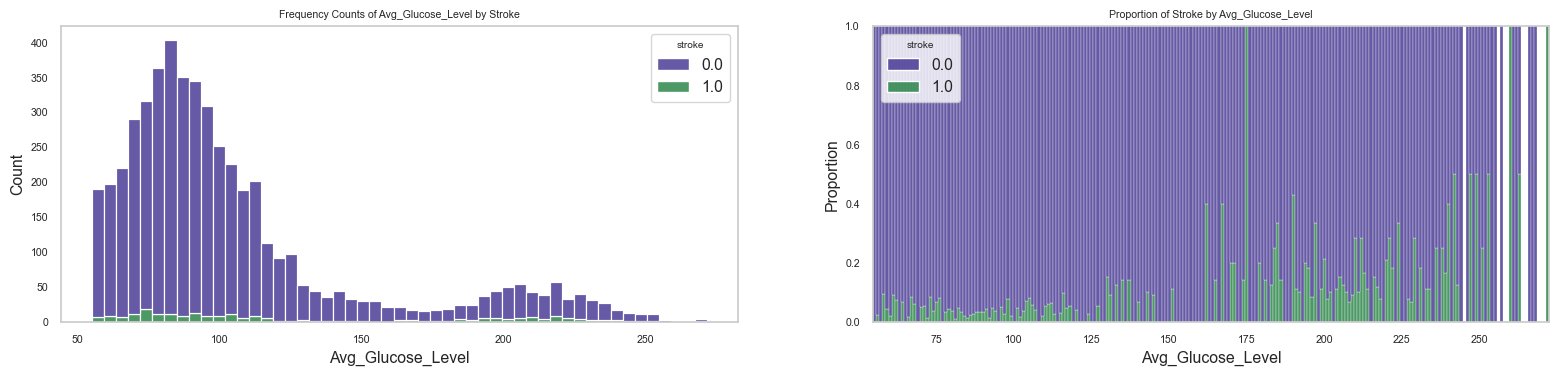

T-statistic: 9.51
P-value: 0.000000
Mean avg_glucose_level of stroke group: 132.54
Mean avg_glucose_level of non-stroke group: 104.80


In [21]:
draw_predictor_target_plots(df_imputed, predictor='avg_glucose_level', target='stroke')
t_test(df_imputed, predictor='avg_glucose_level', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Glucose Levels and Stroke</p>
    <ol>
        <li>The distribution is bimodal, with a smaller group of patients having higher glucose levels</li>
        <li>Proportionally, the risk of stroke seemed to be higher for high glucose levels. Some groups with 240+ blood glucose had 50% or 100% stroke rates</li>
        <li>There is a statistically significant difference in blood glucose level between stroke and non-stroke patients</li>
    </ol>
</div>

### Hypertension

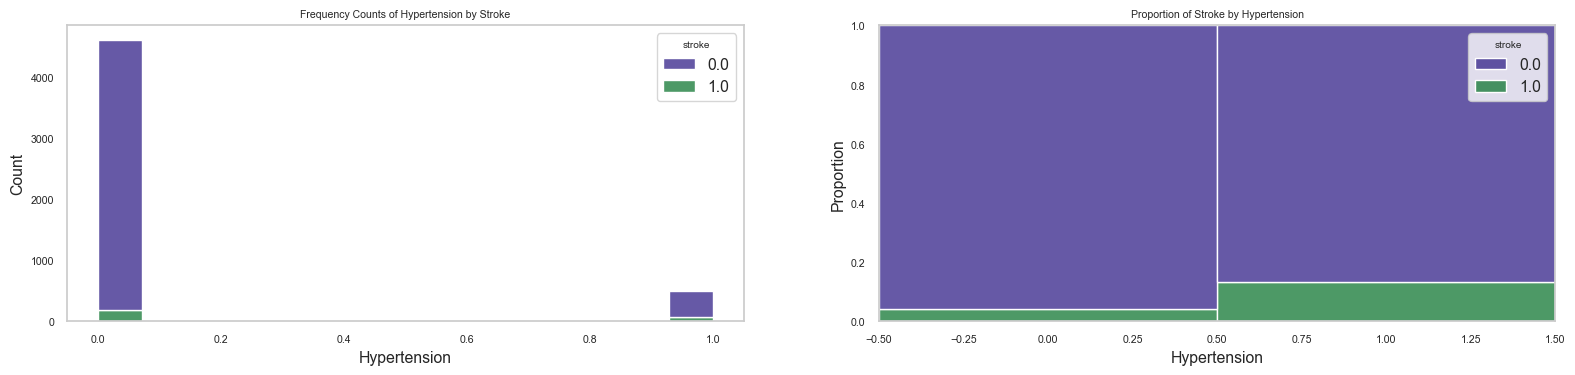

T-statistic: 9.22
P-value: 0.000000
Mean hypertension of stroke group: 0.27
Mean hypertension of non-stroke group: 0.09


In [22]:
draw_predictor_target_plots(df_imputed, predictor='hypertension', target='stroke')
t_test(df_imputed, predictor='hypertension', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Hypertension and Stroke</p>
    <ol>
        <li>There are much less patients with hypertension</li>
        <li>Proportionally, more than 15% of patients with hypertension had a stroke</li>
        <li>Based on the mean of the two groups, the stroke group was more likely to have hypertension</li>
    </ol>
</div>

### Heart Disease

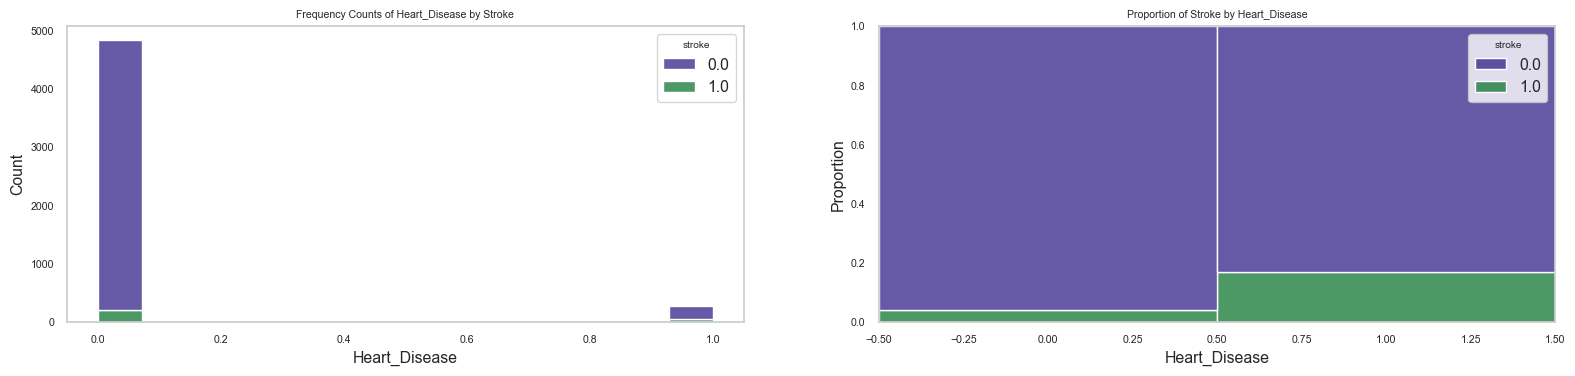

T-statistic: 9.73
P-value: 0.000000
Mean heart_disease of stroke group: 0.19
Mean heart_disease of non-stroke group: 0.05


In [23]:
draw_predictor_target_plots(df_imputed, predictor='heart_disease', target='stroke')
t_test(df_imputed, predictor='heart_disease', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Heart Disease and Stroke</p>
    <ol>
        <li>There are much less patients with heart disease</li>
        <li>Proportionally, about 20% of patients with heart disease had a stroke</li>
        <li>Based on the mean of the two groups, the stroke group was more likely to have a heart disease</li>
    </ol>
</div>

### Bivariate Analysis

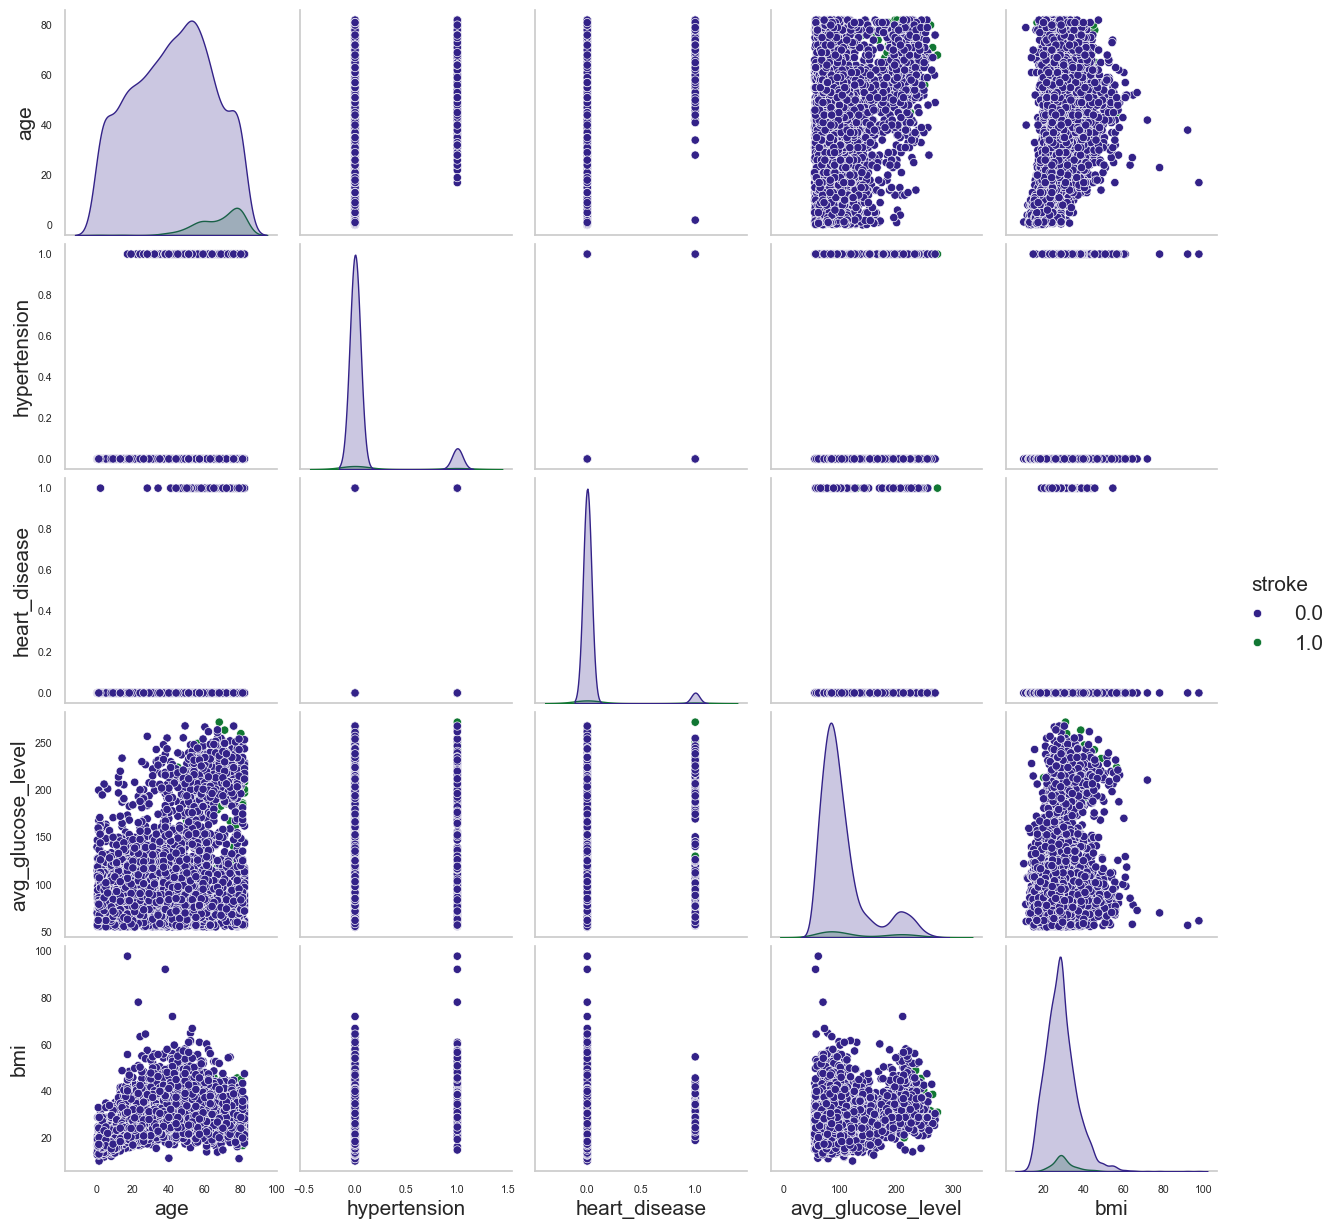

In [24]:
with sns.plotting_context(font_scale=1.5, rc={"axes.titlesize": 20, "axes.labelsize": 15, "legend.fontsize": 15, "legend.title_fontsize": 15}):
    sns.pairplot(df_imputed[numeric_cols], hue='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Bivariate Numeric Feature Analysis</p>
    <ol>
        <li>Hypertension, Heart disease and glucose levels seem to increase with age. BMI is the largest between ages 25-50</li>
        <li>Surprisingly, patients with highest BMI scores do not have large average glucose levels</li>
    </ol>
</div>

## Categorical Predictors
### Gender

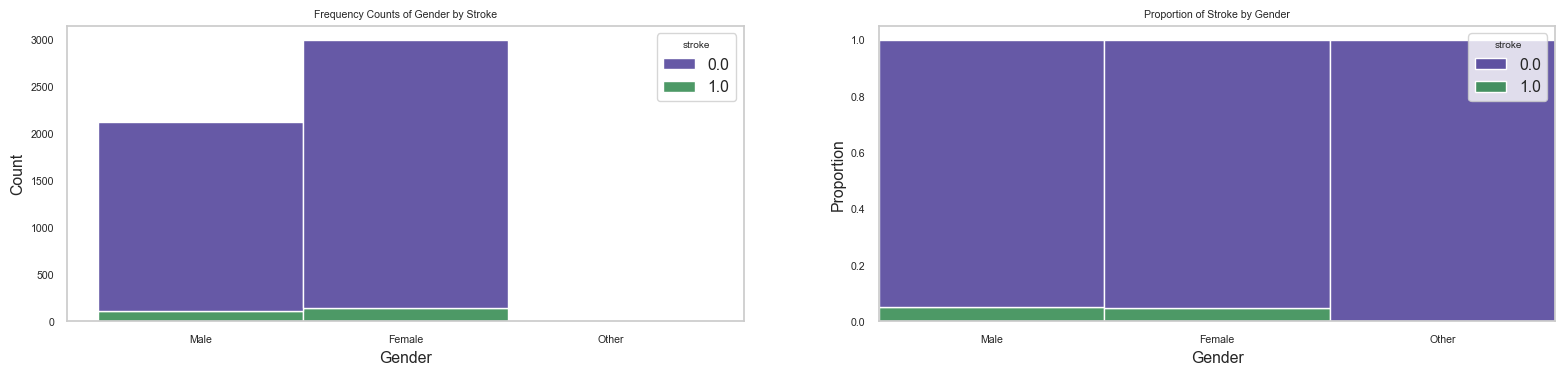

Chi-squared Statistic: 0.4726
P-value: 0.789549


In [25]:
draw_predictor_target_plots(df_imputed, predictor='gender', target='stroke')
chi_squared_test(df_imputed, predictor='gender', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Gender and Stroke</p>
    <ol>
        <li>There are more female patients in the dataset, yet the proportions remain very similar</li>
        <li>The "Other" gender does not have many instances or cases of strokes</li>
        <li>The p-value provides evidence that gender is not a statistically significant feature when differentiating between stroke and non-stroke patients</li>
    </ol>
</div>

### Marriage Status

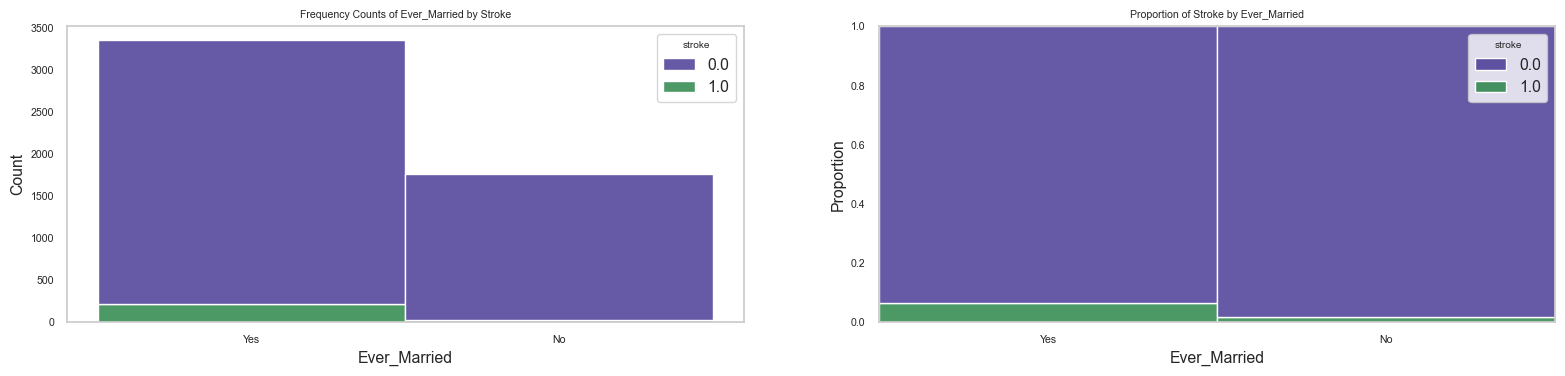

Chi-squared Statistic: 58.9239
P-value: 0.000000


In [26]:
draw_predictor_target_plots(df_imputed, predictor='ever_married', target='stroke')
chi_squared_test(df_imputed, predictor='ever_married', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Marriage Status and Stroke</p>
    <ol>
        <li>There are twice as many married patients in the dataset</li>
        <li>Similarly, married patients in the dataset seemed to have thrice as much stroke cases</li>
        <li>The p-value provides evidence that marriage is a statistically significant feature</li>
    </ol>
</div>

### Work Type

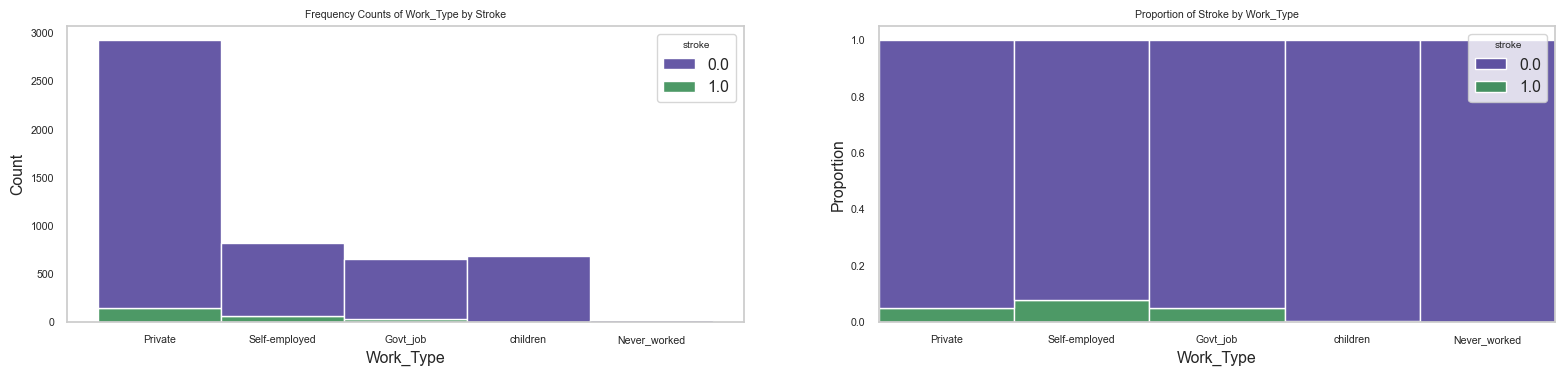

Chi-squared Statistic: 49.1635
P-value: 0.000000


In [27]:
draw_predictor_target_plots(df_imputed, predictor='work_type', target='stroke')
chi_squared_test(df_imputed, predictor='work_type', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Work Type and Stroke</p>
    <ol>
        <li>Work in the private sector is the most prevalent category in the dataset</li>
        <li>Proportionally, self-employed individuals were the most likely to suffer a stroke; Private and Government employees shared a similar proportion</li>
        <li>The p-value provides evidence that work type is a statistically significant feature</li>
    </ol>
</div>

### Residence Type

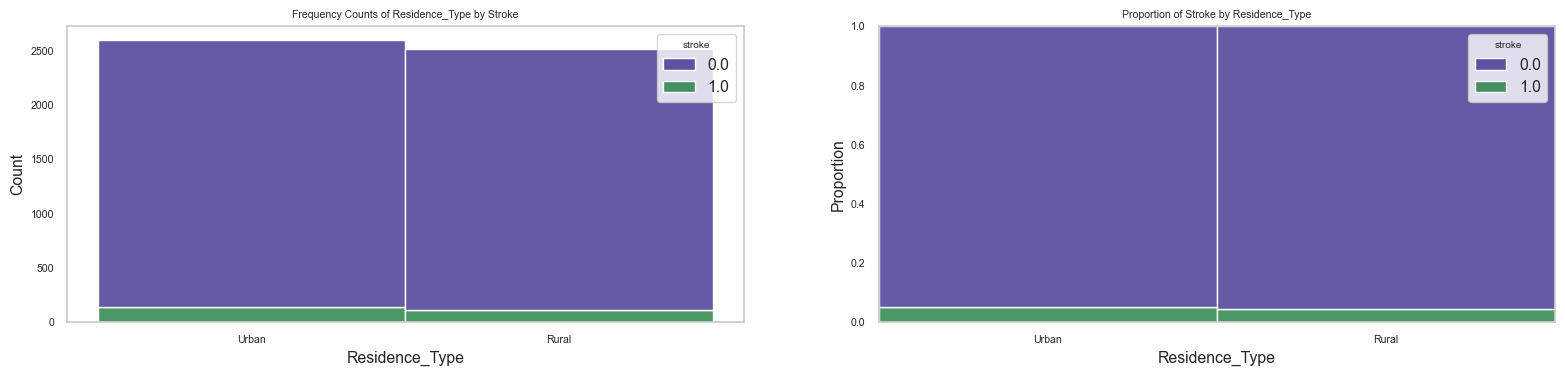

Chi-squared Statistic: 1.0816
P-value: 0.298332


In [28]:
draw_predictor_target_plots(df_imputed, predictor='residence_type', target='stroke')
chi_squared_test(df_imputed, predictor='residence_type', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Residence Type and Stroke</p>
    <ol>
        <li>The dataset has an almost equal split of Urban and Rural residence patients</li>
        <li>Proportionally, both classes are very similar.</li>
        <li>The p-value does not provide strong enough evidence that residence type is a statistically significant feature</li>
    </ol>
</div>

### Smoking Status

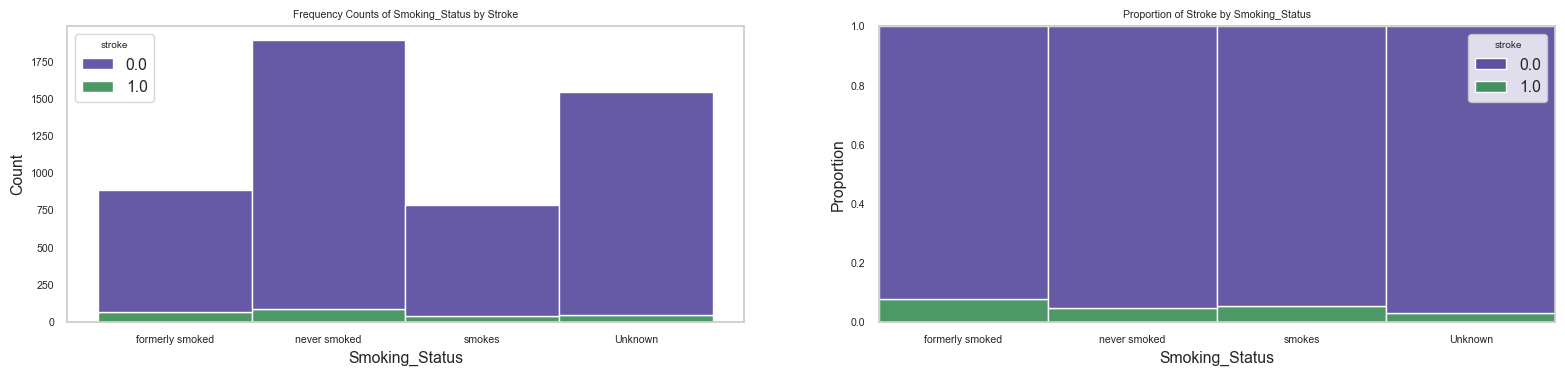

Chi-squared Statistic: 29.1473
P-value: 0.000002


In [29]:
draw_predictor_target_plots(df_imputed, predictor='smoking_status', target='stroke')
chi_squared_test(df_imputed, predictor='smoking_status', target='stroke')

<div class="findings">
    <h3>Findings</h3>
    <p>Smoking Status and Stroke</p>
    <ol>
        <li>Non-smokers are the largest category of patients; Additionally, a big part of patients did not provide their smoking status or were not asked</li>
        <li>Proportionally, former smokers seemed to have the biggest proportion of stroke cases. Surprisingly, current smokers and non-smokers shared similar proportions</li>
        <li>The p-value provides evidence that smoking status is a statistically significant feature</li>
    </ol>
</div>

## Feature Correlations
Let's see how the predictors interact between each other and with the target variable.
* Correlation between numeric variables - **Spearman**
* Correlation between categorical variables - **Cramer's V**
* Correlation between all variables - **eta coefficient**

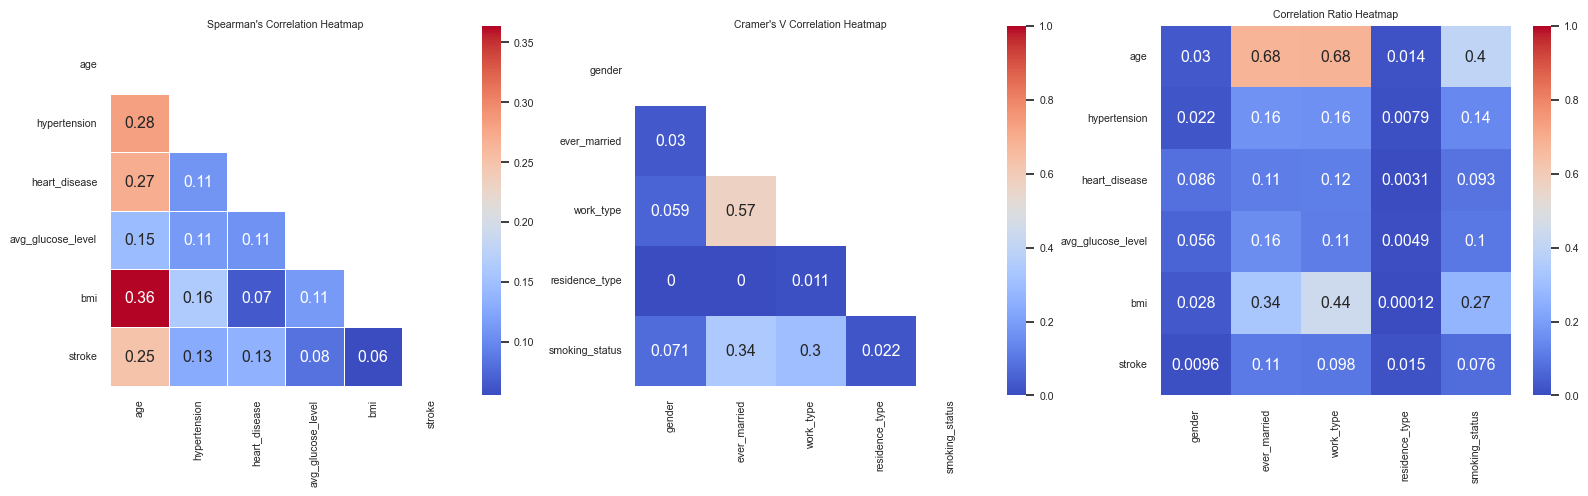

In [30]:
correlation_matrices(df_imputed, numeric_cols, categorical_cols)

<div class="findings">
    <h3>Findings</h3>
    <p>Features' correlation</p>
    <ol>
        <li>The target variable <b>Stroke</b> does not have any strong or moderate correlations; <b>Stroke - Age</b> is a weak positive correlation</li>
        <li><b>BMI</b> and <b>Age</b> have the strongest positive correlation among numerical variables</li>
        <li><b>Work Type</b> and <b>Marriage Status</b> have the strongest positive correlation among categorical variables</li>
        <li><b>Age</b> has the largest positive correlations with <b>Marriage Status</b> and <b>Work Type</b>, potentially suggesting that marriage status and work type may be consistent for specific age groups</li>
    </ol>
</div>

## Mutual Information
For the Mutual Information part, we will need to encode the categorical features.

In [31]:
df_imputed_encoded = pd.get_dummies(df_imputed, columns=categorical_cols, drop_first=True)

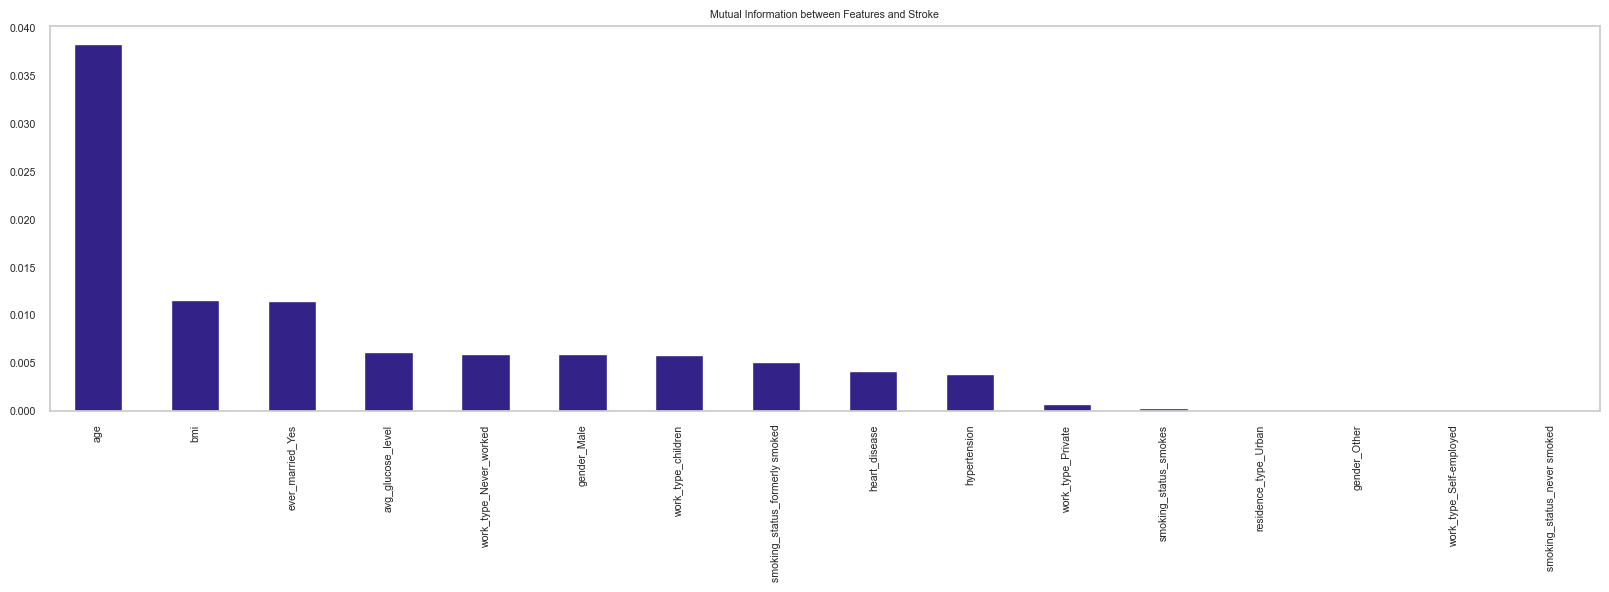

In [32]:
X_mi = df_imputed_encoded.drop(columns=['id', 'stroke'])
y_mi = df_imputed_encoded['stroke']
target_name = 'stroke'

mi = mutual_info_classif(X_mi, y_mi, discrete_features='auto', random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_mi.columns)
plt.figure(figsize=(20, 5))
mi_series.sort_values(ascending=False).plot.bar()
plt.title(f'Mutual Information between Features and {target_name.title()}')
plt.show()

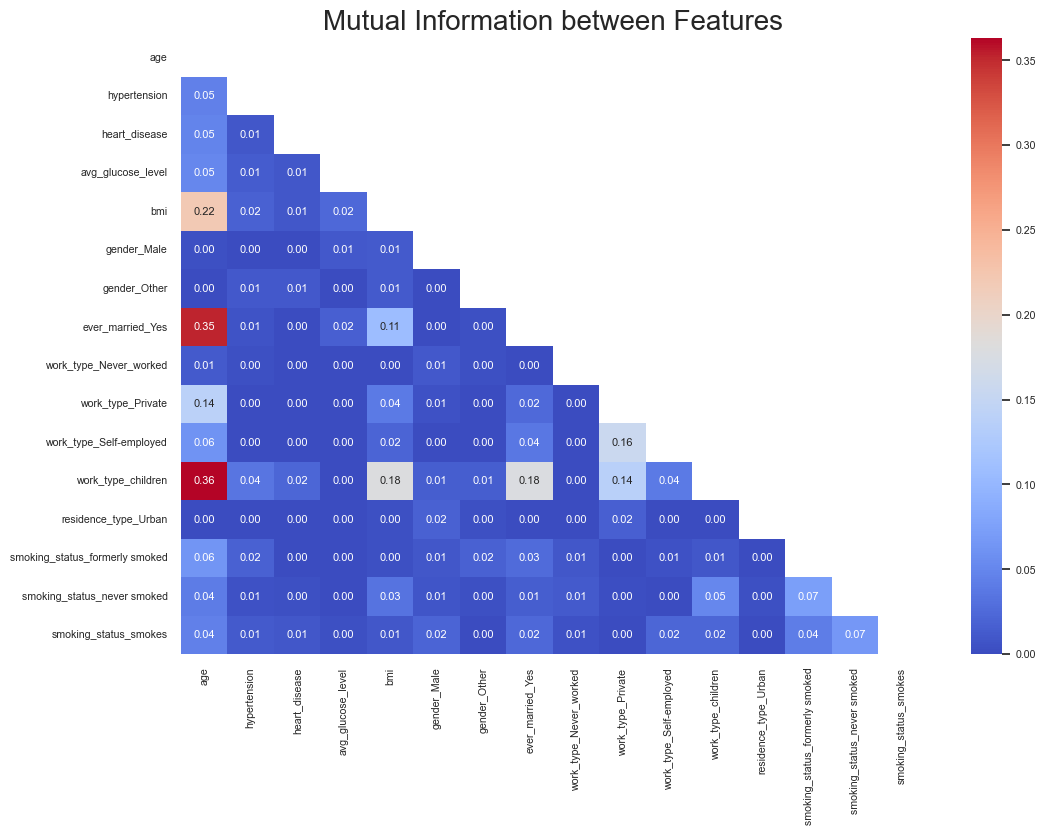

In [33]:
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information between features
mi_matrix = pd.DataFrame(index=X_mi.columns, columns=X_mi.columns)
for i in X_mi.columns:
    for j in X_mi.columns:
        if i != j:
            mi_matrix.loc[i, j] = mutual_info_regression(X_mi[[i]], X_mi[j]).item()

# Plot mutual information matrix
with sns.plotting_context(font_scale=0.6, rc={"axes.titlesize": 20, "axes.labelsize": 15, "font.size": 8}):
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(mi_matrix, dtype=bool))
    sns.heatmap(mi_matrix.astype(float), annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Mutual Information between Features')
    plt.show()


<div class="findings">
    <h3>Findings</h3>
    <p>Mutual Information</p>
    <ol>
        <li><b>Age</b> has the highest MI score when it comes to identifying stroke risks</li>
        <li>All numeric features had relatively high MI scores</li>
        <li><b>Married</b> patients had the highest MI score out of the categorical features</li>
        <li><b>Age - Marriage</b> and <b>Age - Work Type (children)</b> have moderate MI scores. We can attribute this to the fact that the database includes children; This population group is less likely to work or be married</li>
        <li>As seen previously in the Bivariate Analysis, <b>BMI - Age</b> is reflected as the middle age group having the highest BMI</li>
    </ol>
</div>

## Outliers

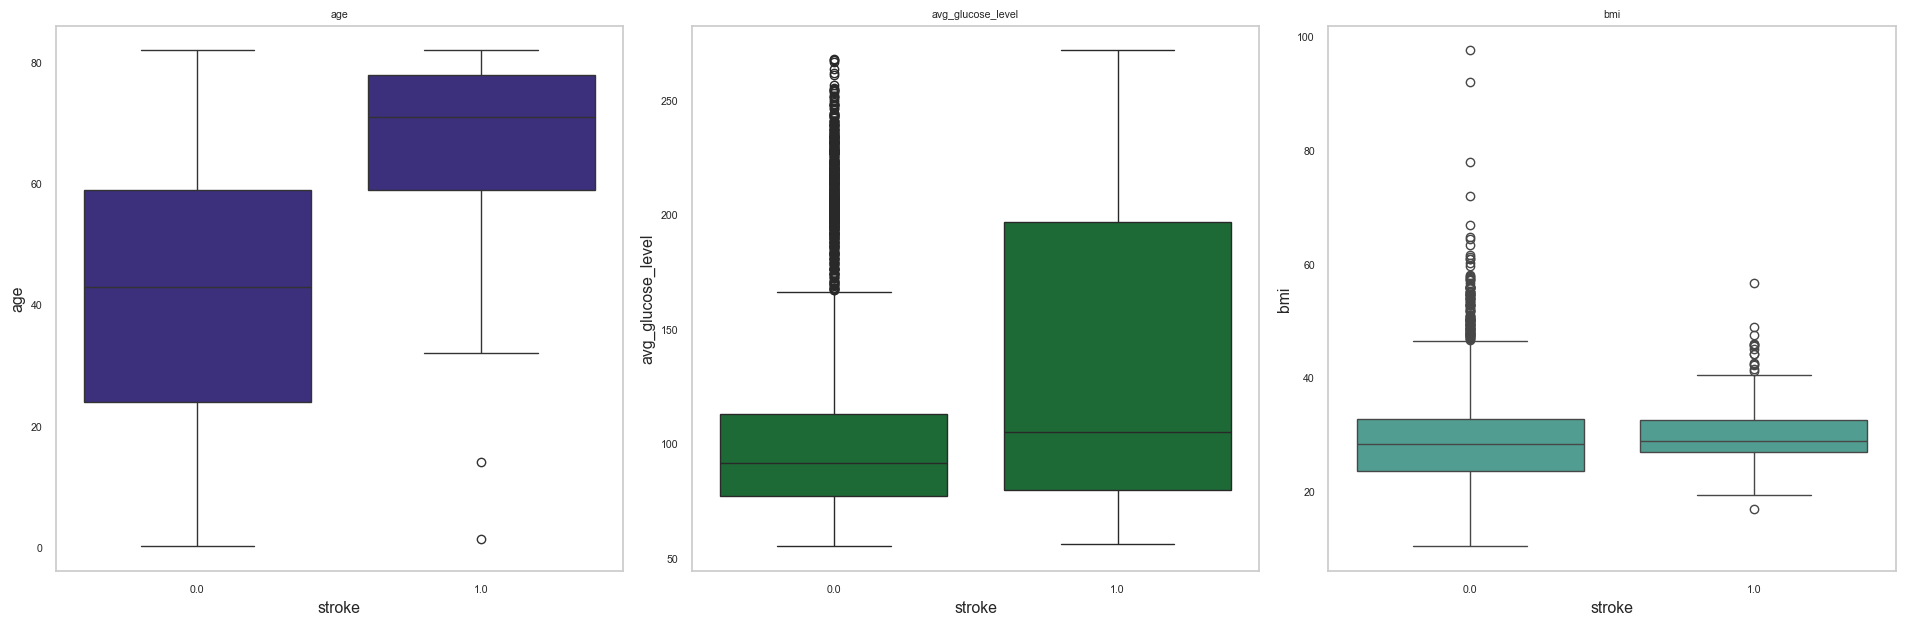

In [34]:
numeric_cols_excl_binary = [col for col in numeric_cols if col not in ['hypertension', 'heart_disease', 'stroke']]
draw_boxplots(df_imputed, target='stroke', predictors=numeric_cols_excl_binary)

<div class="findings">
    <h3>Findings</h3>
    <p>Numerical Variables: Outliers</p>
    <ol>
        <li>There are two cases of children who had a stroke. The middle 50% of the patients who had a stroke is between ages 60 to 80</li>
        <li>There are a lot of cases where patients with high glucose levels did not have a stroke. Generally, higher glucose levels resulted in a stroke</li>
        <li>Similarly to blood glucose, there are a lot of patients with very large BMIs who did not have a stroke. Stroke patients generally clustered around 30-35 BMI</li>
    </ol>
</div>

# Statistical Modeling
* Data Split: **cross-validation**
* Performance Metric: **positive recall & ROC-AUC score**
* Baseline Model: **Random Forest Classifier**
* Tested Models: **Logistic Regression, Random Forest Classifier, XGBoost, LightGBM**

## Model Pipeline
For each cross-validation fold, we need to perform the following:
* **Imputation**: KNN imputation for numeric features, most-frequent imputation for categorical.
* **Transformation**: Scaling for numeric features, One-Hot-Encoding for categorical.

The output of the Pipeline will be used as a baseline.

In [35]:
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']

numerical_features = ['age', 'avg_glucose_level', 'bmi', 'heart_disease', 'hypertension']
categorical_features = ['gender', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

## Model Baseline

In [36]:

numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf)
])

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_pred = cross_val_predict(pipeline, X, y, cv=cv)
y_pred_proba = cross_val_predict(pipeline, X, y, cv=cv,
                                 method='predict_proba')[:, 1]

Baseline Model
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4861
           1       0.20      0.01      0.02       249

    accuracy                           0.95      5110
   macro avg       0.58      0.50      0.50      5110
weighted avg       0.92      0.95      0.93      5110

ROC-AUC Score: 0.778315


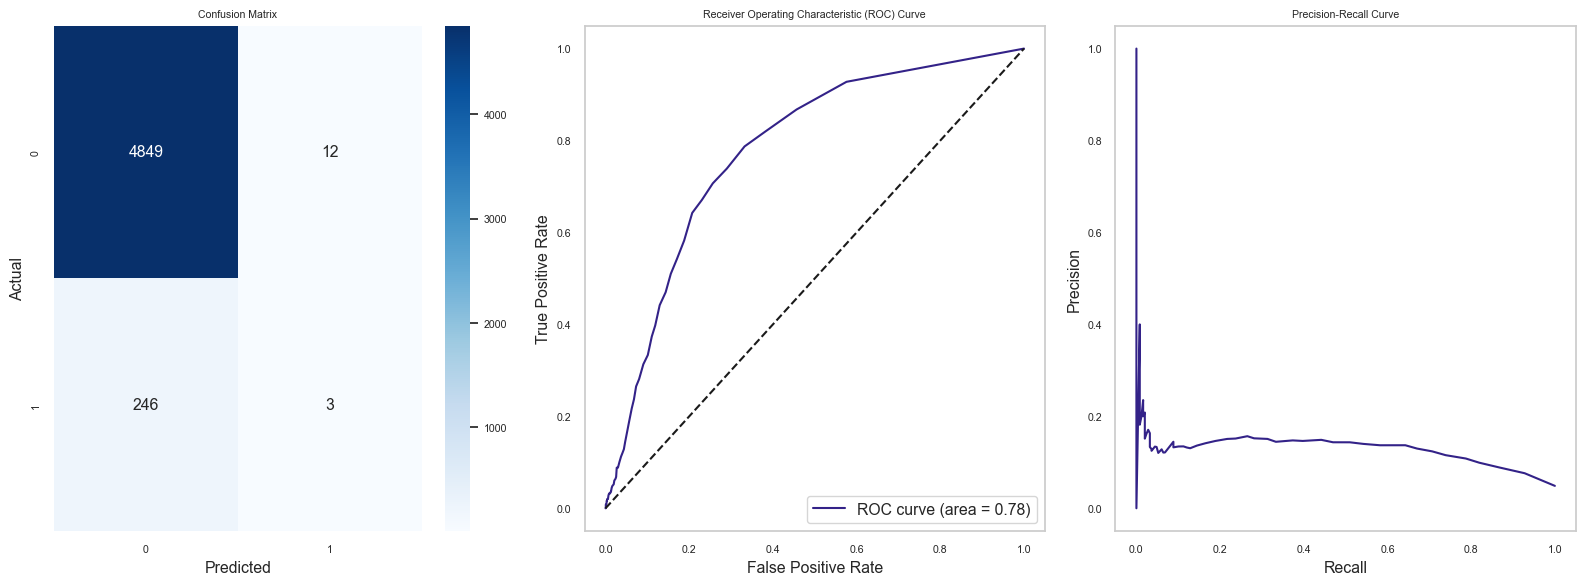

In [37]:
print("Baseline Model")
print(classification_report(y, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba), 6))
visualize_performance(y, y_pred, y_pred_proba)

<div class="results">
    <h3>Model Results</h3>
    <p>Baseline Model</p>
    <ol>
        <li>Almost 95% accuracy, indicating that only 5% of cases were incorrect.</li>
        <li>Precision and recall for stroke cases are very poor, at 20% and 1% respectively.</li>
        <li>The ROC-AUC score may seem great, but it is largely influenced by true negatives and the imbalanced dataset</li>
        <li>Precision is quite low across all recall levels, which means when the model predicts a stroke, it is often incorrect</li>
    </ol>
</div>

We will use **recall** and **ROC-AUC score** as two performance metrics. Recall is critical as we must reduce false negatives (missing a stroke) as much as possible. The ROC-AUC score will provide us with the overall view of how the model discerns between stroke and non-stroke cases. Let's store the baseline scores.

In [38]:
baseline_recall = recall_score(y, y_pred)
baseline_precision = precision_score(y, y_pred)
baseline_roc_auc = roc_auc_score(y, y_pred_proba)
baseline_scores = [baseline_recall, baseline_precision, baseline_roc_auc]

Let's initialize our models and parameter grid variables, which we will update throughout the process.

In [39]:
models = {
    'Baseline': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
}
param_grids = {
    'Baseline': {},
    'Logistic Regression': {},
    'Random Forest': {},
    'XGBoost': {},
}
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ])

## Class Weights
The first step is to address the dataset imbalance problem; Only 5% of the instances have patients who experienced a stroke. Other feature engineering opportunities will not show any noticeable benefits until we set this part first.

In [40]:
scale_pos_weight = (len(y) - sum(y)) / sum(y)

for name, model in models.items():
    if name == 'Logistic Regression' or name == 'Random Forest':
        model.set_params(class_weight='balanced')
    elif name == 'XGBoost':
        model.set_params(scale_pos_weight=scale_pos_weight)

Best parameters for Logistic Regression: {}
Best parameters for Random Forest: {}
Best parameters for XGBoost: {}


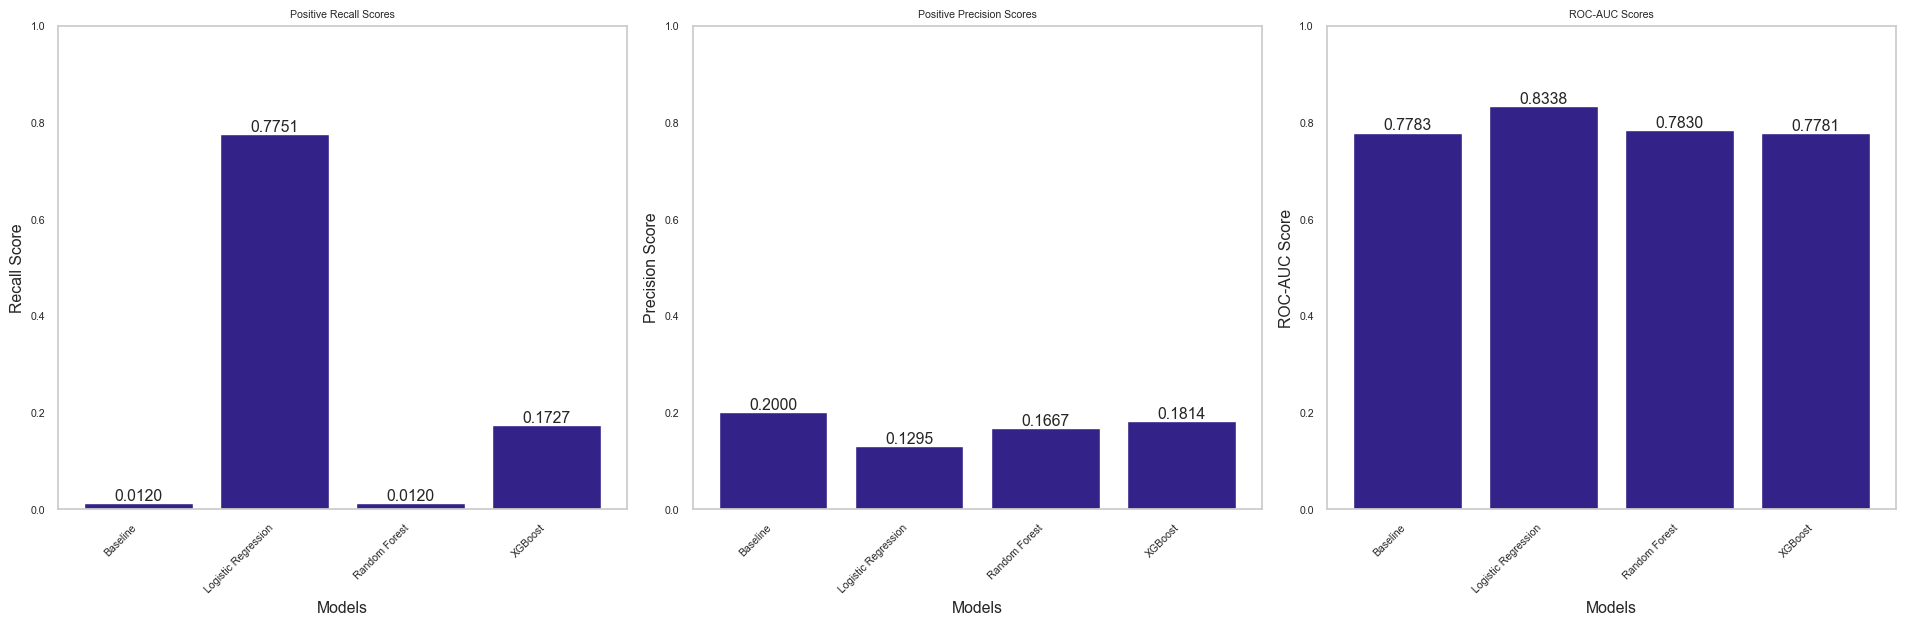

In [41]:
benchmark_models(pipeline, param_grids, models, X, y, cv, baseline_scores)

<div class="results">
    <h3>Model Results</h3>
    <p>Class Weights</p>
    <ol>
        <li>With class weights implementation, the Logistic Regression has very good positive recall performance. Unfortunately, the precision score is the worst, which indicates that the model has a lot of false positives (predicting non-stroke patients as potentially at a risk of stroke). While positive precision is not our focus, it would be costly to have so many false positives</li>
        <li>XGBoost has the most similar positive precision and recall so far</li> 
    </ol>
</div>

## Feature Transformations
The next step is performing numerical features transformations to get better performance and reduce overfitting.
* Log transformations for skewed features
* Binning of numerical variables into categorical features

<div class="Note">
    <h3>Note</h3>
    <p>The issue with BMI</p>
    <ul>
        <li>Some instances do not have BMI specified. We will use the same kNN inputer as in the baseline to create a dataset with imputed values.</li>
    </ul>
</div>

In [42]:
imputer = KNNImputer(n_neighbors=3)
X_imputed = X.copy()
X_imputed['bmi'] = imputer.fit_transform(X[['bmi']])

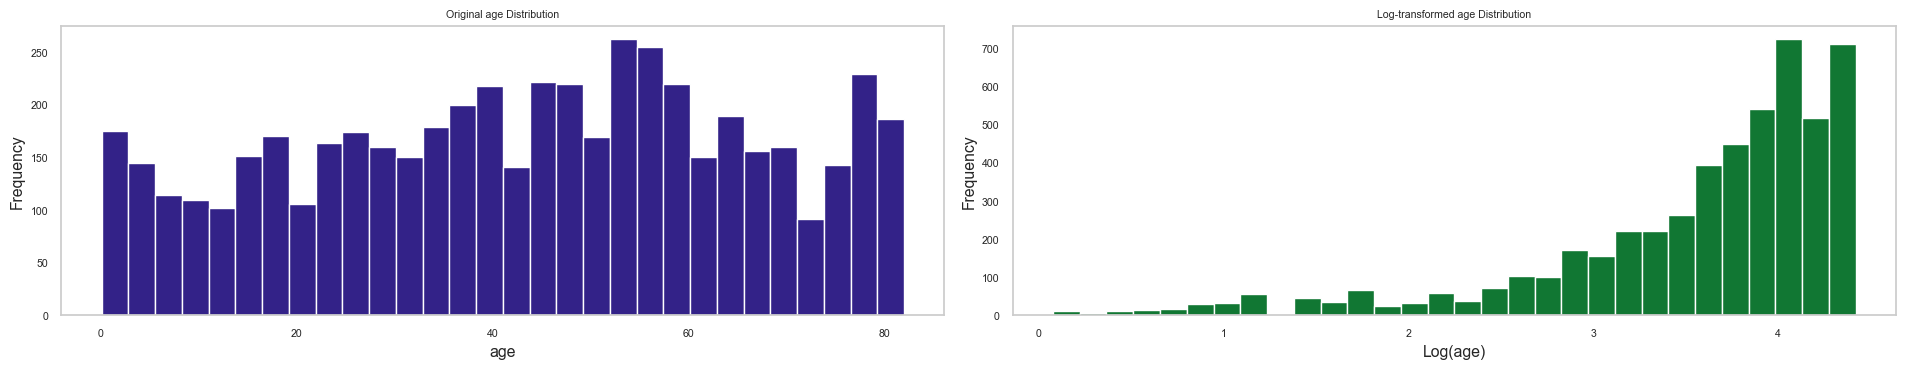

age skewness: -0.14
No transformation needed


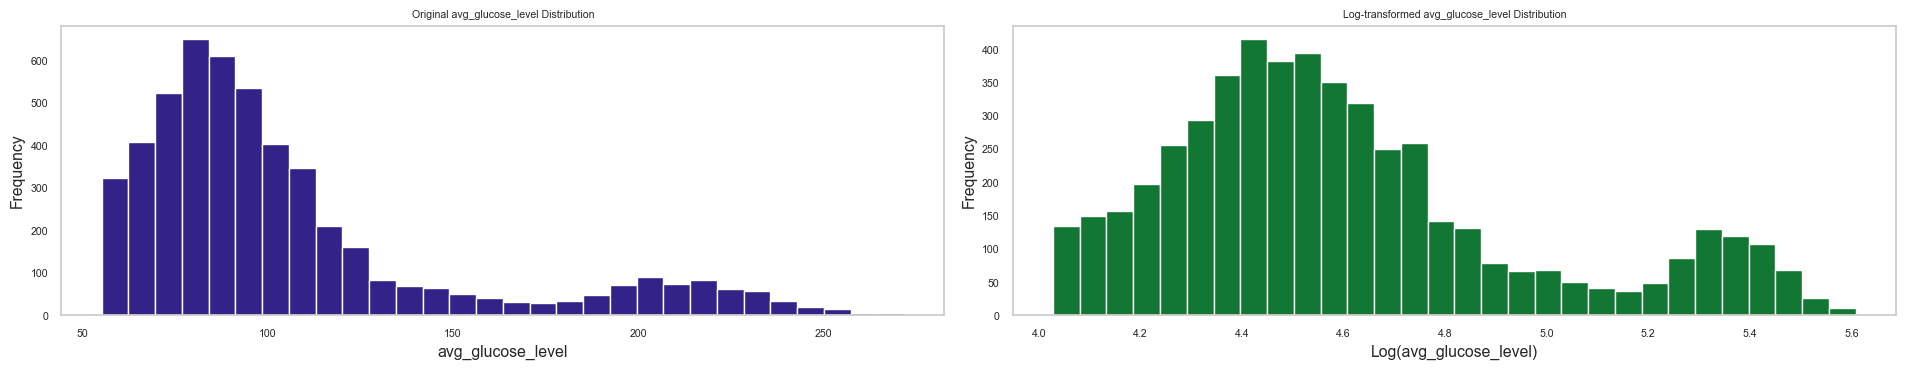

avg_glucose_level skewness: 1.57
Log transformation applied. Column avg_glucose_level_log
Log-transformed avg_glucose_level skewness: 0.89


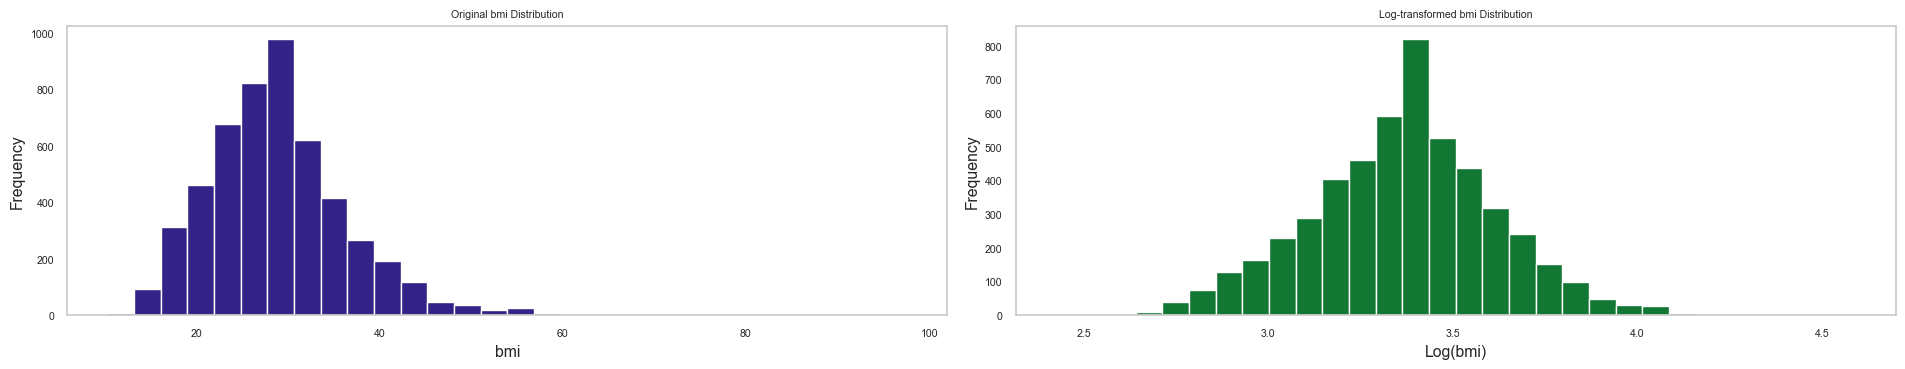

bmi skewness: 1.08
Log transformation applied. Column bmi_log
Log-transformed bmi skewness: 0.02


In [43]:
for feature in numeric_cols_excl_binary:
    draw_original_log_distribution(X_imputed, feature)
    print(f"{feature} skewness: {X_imputed[feature].skew():.2f}")
    # Apply log transformation if skewness is significant
    if abs(X_imputed[feature].skew()) > 0.5:
        X_imputed[f'{feature}_log'] = np.log1p(X_imputed[feature])
        print(f"Log transformation applied. Column {feature}_log")
        print(f"Log-transformed {feature} skewness: {X_imputed[f'{feature}_log'].skew():.2f}")
    else:
        print("No transformation needed")

Log transformation reduced the skewness for `avg_glucose_level` and `bmi` significantly.

Let's create some new features next.

In [44]:
# Grouping
X_imputed['bmi_category'] = X_imputed['bmi'].apply(bmi_category)
X_imputed['age_group'] = X_imputed['age'].apply(age_group)
X_imputed['glucose_category'] = X_imputed['avg_glucose_level'].apply(glucose_category)

# Score calculation
X_imputed['lifestyle_score'] = X_imputed.apply(lifestyle_score, axis=1)
X_imputed['work_stress_proxy'] = X_imputed.apply(work_stress_proxy, axis=1)

# Categorical to numerical / binary
smoking_risk = {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': 0}
X_imputed['smoking_risk'] = X_imputed['smoking_status'].map(smoking_risk)

# Numerical interactions
X_imputed['age_bmi_interaction'] = X_imputed['age'] * X_imputed['bmi']
X_imputed['glucose_bmi_interaction'] = X_imputed['avg_glucose_level'] * X_imputed['bmi']


In [45]:
# Update the list of numerical and categorical features
numerical_features = X_imputed.select_dtypes(exclude='object').columns
categorical_features = X_imputed.select_dtypes(include='object').columns

Before we benchmark, let's look at feature correlations and remove redundant features.

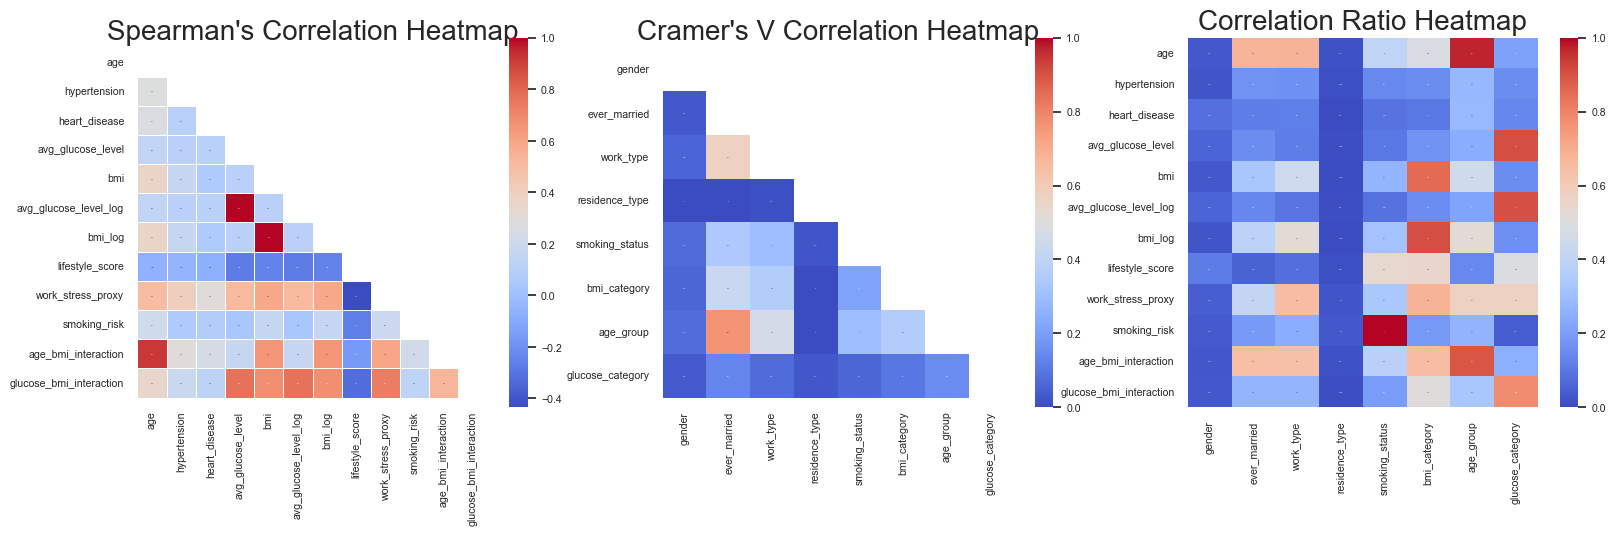

In [46]:
with sns.plotting_context(font_scale=0.6, rc={"axes.titlesize": 20, "axes.labelsize": 15, "font.size": 0}):
    correlation_matrices(X_imputed, numerical_features, categorical_features)

In [47]:
X_imputed = X_imputed.drop(['bmi', 'avg_glucose_level', 'smoking_status'], axis=1)

In [48]:
numerical_features = X_imputed.select_dtypes(exclude='object').columns
categorical_features = X_imputed.select_dtypes(include='object').columns
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])
pipeline = Pipeline([
        ('preprocessor', preprocessor),
])

Best parameters for Logistic Regression: {}
Best parameters for Random Forest: {}
Best parameters for XGBoost: {}


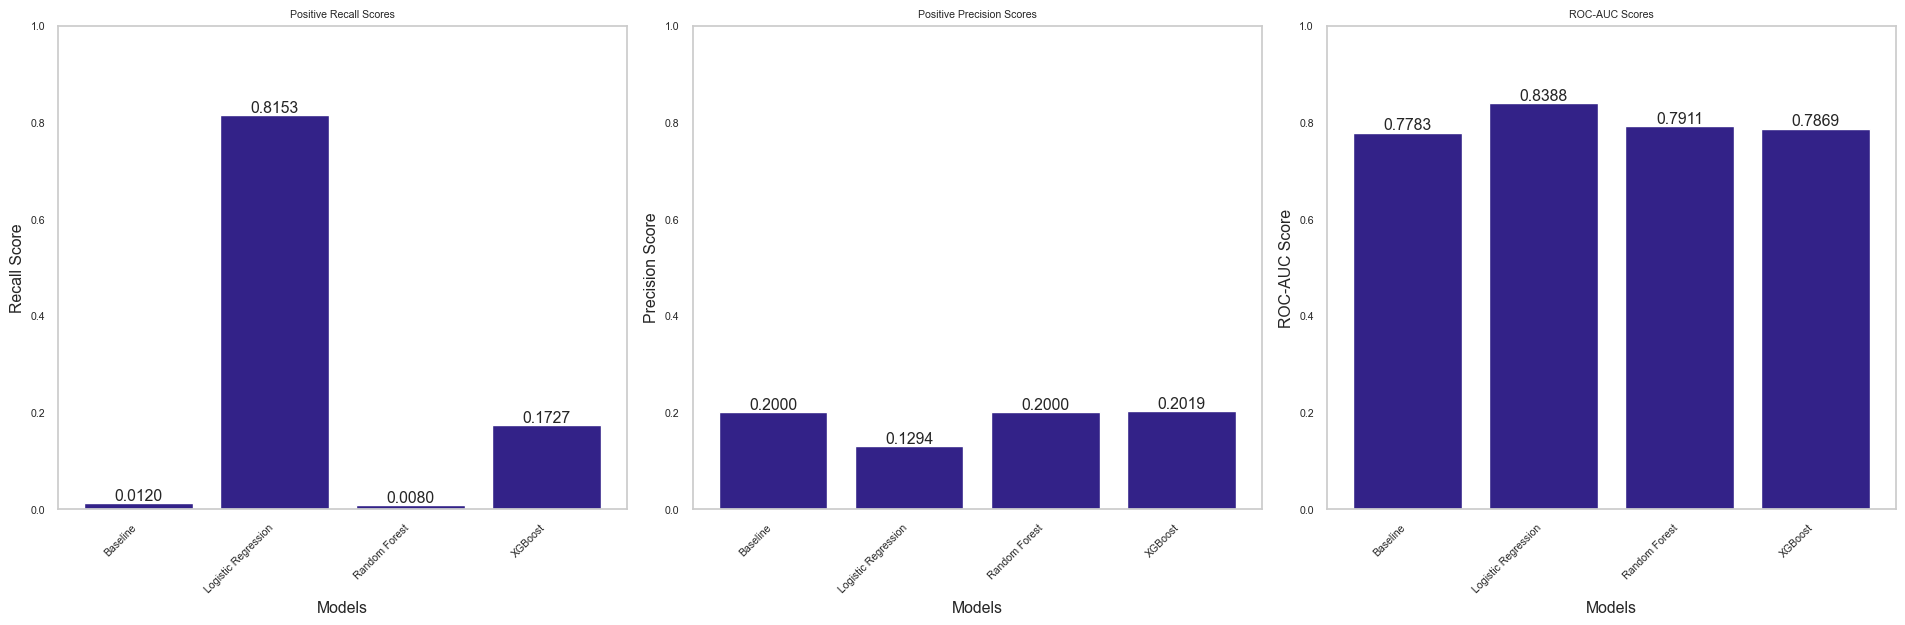

In [49]:
benchmark_models(pipeline, param_grids, models, X_imputed, y, cv, baseline_scores)

<div class="results">
    <h3>Model Results</h3>
    <p>Feature Transformation & addition</p>
    <ul>
        <li>Logistic Regression - adding new features and removing multicollinear features improved all metrics</li>
        <li>Random Forest - performs worse than baseline in positive recall, will need further adjustments</li>
        <li>XGBoost - slight performance improvement in positive precision</li>
    </ul>
</div>

We have a solid base to tune each of our models individually. After we've exhausted their options, we will create a meta-model through the stacking classifier.

## Logistic Regression Model
First, let's work on optimizing the Logistic regression model.

In [50]:
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

resampler_lr = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)

pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor_lr),
    ('resampler', resampler_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))),
    ('model', LogisticRegression(random_state=RANDOM_STATE)),
])

param_grid_lr = {
    'model__C': [0.1, 0.5, 1, 5, 10],
    'model__penalty': ['l2', 'elasticnet'],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'model__max_iter': [1000, 5000, 10000],
    'model__l1_ratio': [0, 0.1, 0.5, 0.7, 1],
    'model__warm_start': [True, False],
    'model__intercept_scaling': [1, 2, 3, 4, 5],
    'model__fit_intercept': [True, False],
    'feature_selection__threshold': ['mean', 'median', '2.*mean'],
    'feature_selection__estimator__penalty': ['l1', 'l2'],
    'feature_selection__estimator__C': [0.1, 0.5, 1.0, 5, 10],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
}

Best parameters for Logistic Regression: {'preprocessor__num__scaler': MinMaxScaler(), 'model__warm_start': True, 'model__solver': 'saga', 'model__penalty': 'l2', 'model__max_iter': 10000, 'model__l1_ratio': 0.5, 'model__intercept_scaling': 5, 'model__fit_intercept': True, 'model__class_weight': None, 'model__C': 5, 'feature_selection__threshold': 'mean', 'feature_selection__estimator__penalty': 'l1', 'feature_selection__estimator__C': 10

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      4861
           1       0.13      0.80      0.22       249

    accuracy                           0.73      5110
   macro avg       0.56      0.76      0.53      5110
weighted avg       0.94      0.73      0.81      5110

ROC-AUC Score: 0.840245


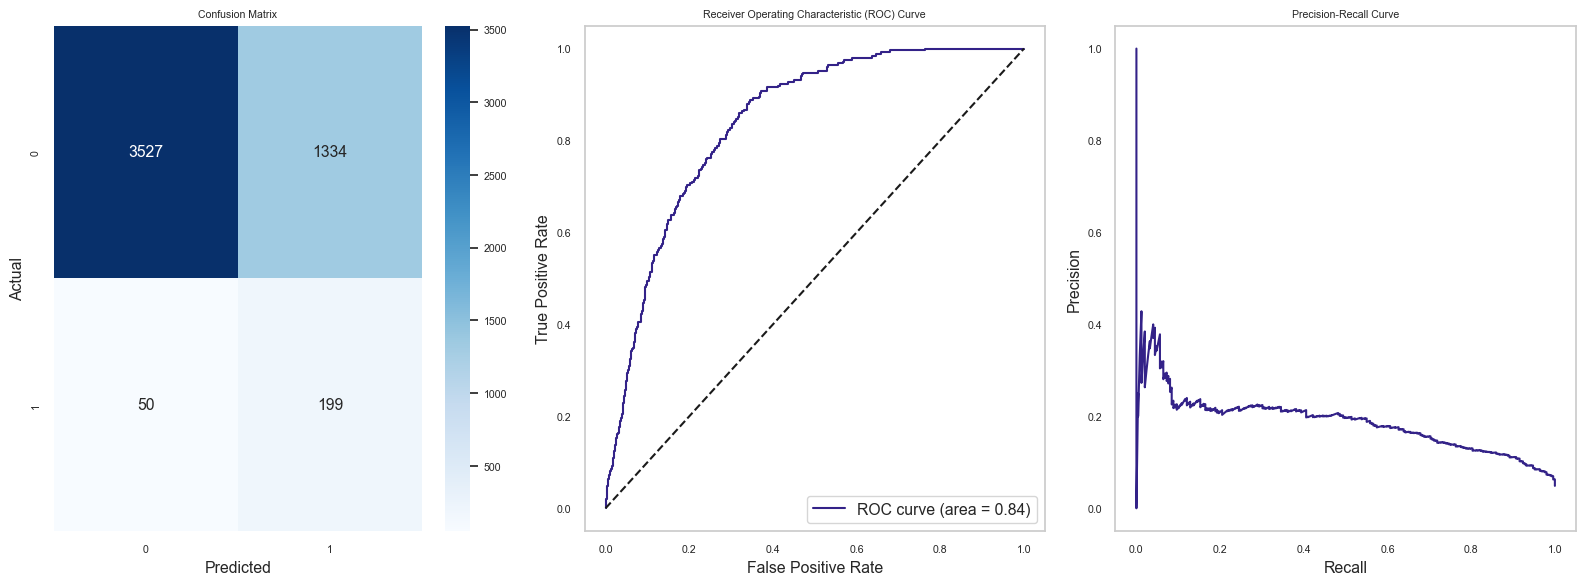

In [51]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average='micro', pos_label=1)

grid_search_lr = RandomizedSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE,
)

grid_search_lr.fit(X_imputed, y)
best_model = grid_search_lr.best_estimator_
y_pred = cross_val_predict(best_model, X_imputed, y, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_imputed, y, cv=cv, method='predict_proba')[:, 1]

print(classification_report(y, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba), 6))
visualize_performance(y, y_pred, y_pred_proba)

## Random Forest Model
Second, let's improve the random forest model through hyperparameter tuning.

In [52]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

resampler_rf = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)

pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor_rf),
    ('resampler', resampler_rf),
    ('feature_selection', SelectFromModel(BalancedRandomForestClassifier(random_state=RANDOM_STATE, replacement=True, bootstrap=True))),
    ('model', BalancedRandomForestClassifier(random_state=RANDOM_STATE, replacement=True, bootstrap=True)),
])

param_grid_rf = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 5, 10, 15, 20],
    'model__min_samples_leaf': [1, 2, 4, 6, 8],
    'model__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'model__replacement': [True, False],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'feature_selection__estimator__n_estimators': [50, 100, 150, 200],
    'feature_selection__estimator__criterion': ['gini', 'entropy'],
    'feature_selection__estimator__bootstrap': [True, False],
    'feature_selection__estimator__warm_start': [True, False],
}

Best parameters for Random Forest: {'model__replacement': False, 'model__n_estimators': 500, 'model__min_samples_split': 20, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 50, 'model__class_weight': {0: 1, 1: 20}, 'feature_selection__estimator__warm_start': True, 'feature_selection__estimator__n_estimators': 100, 'feature_selection__estimator__criterion': 'entropy', 'feature_selection__estimator__bootstrap': True}
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      4861
           1       0.16      0.55      0.25       249

    accuracy                           0.84      5110
   macro avg       0.57      0.70      0.58      5110
weighted avg       0.93      0.84      0.88      5110

ROC-AUC Score: 0.81081


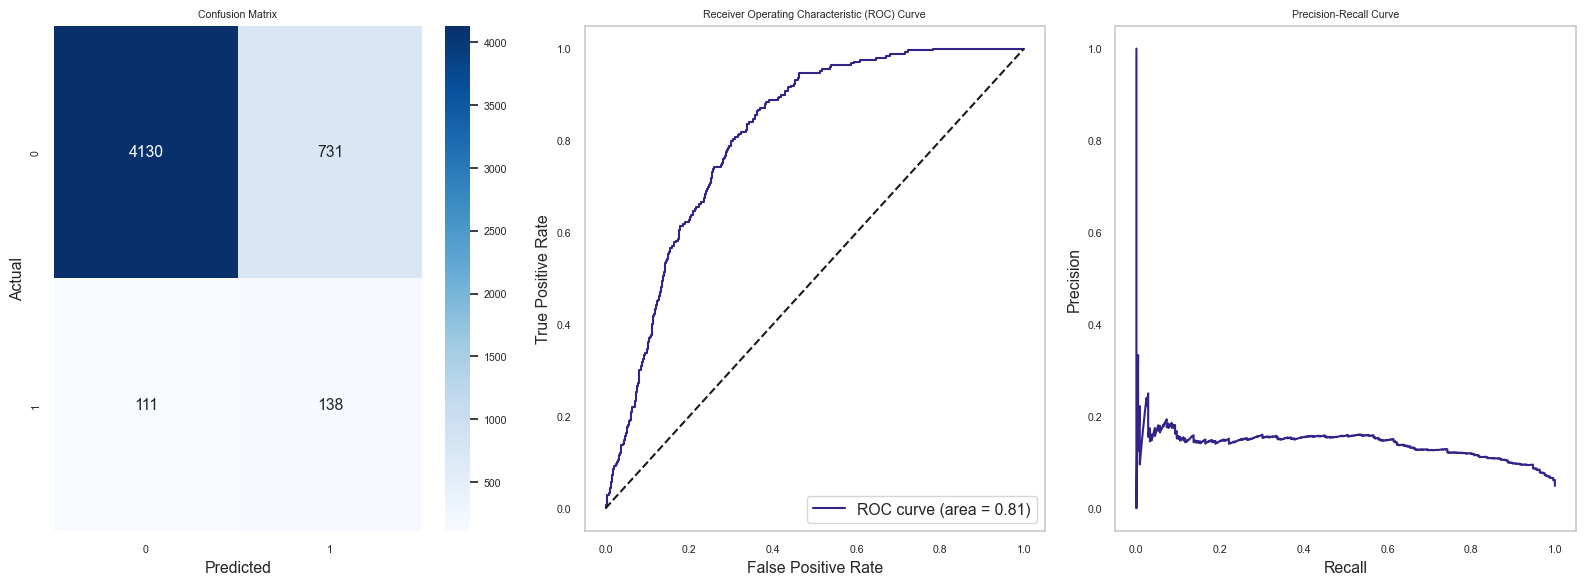

In [53]:
from sklearn.metrics import make_scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE
)

grid_search_rf.fit(X_imputed, y)
best_model = grid_search_rf.best_estimator_
y_pred = cross_val_predict(best_model, X_imputed, y, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_imputed, y, cv=cv, method='predict_proba')[:, 1]

print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(classification_report(y, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba), 6))
visualize_performance(y, y_pred, y_pred_proba)

Best parameters for Random Forest: {'model__replacement': False, 'model__n_estimators': 500, 'model__min_samples_split': 20, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 50, 'model__class_weight': {0: 1, 1: 20}, 'feature_selection__estimator__warm_start': True, 'feature_selection__estimator__n_estimators': 100, 'feature_selection__estimator__criterion': 'entropy', 'feature_selection__estimator__bootstrap': True}

## XGB Classifier

In [54]:
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

resampler_xgb = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_STATE)

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor_xgb),
    ('resampler', resampler_xgb),
    ('feature_selection', SelectFromModel(XGBClassifier(random_state=RANDOM_STATE))),
    ('model', XGBClassifier(random_state=RANDOM_STATE)),
])

param_grid_xgb = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__n_estimators': [100, 200, 500, 1000],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.5, 0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'model__scale_pos_weight': [1, 5, 10, 50, 100],
    'model__gamma': [0, 0.1, 0.2, 0.5],
    'model__reg_alpha': [0, 0.1, 1, 10],
    'model__reg_lambda': [0, 0.1, 1, 10],
    'model__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'preprocessor__num__scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()],
    'feature_selection__estimator__n_estimators': [50, 100, 150, 200],
    'feature_selection__estimator__criterion': ['gini', 'entropy'],
    'feature_selection__estimator__bootstrap': [True, False],
    'feature_selection__estimator__warm_start': [True, False],
}

Best parameters for XGB: {'preprocessor__num__scaler': RobustScaler(), 'model__subsample': 1.0, 'model__scale_pos_weight': 1, 'model__reg_lambda': 0.1, 'model__reg_alpha': 10, 'model__n_estimators': 500, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__colsample_bytree': 0.7, 'model__class_weight': 'balanced', 'feature_selection__estimator__warm_start': False, 'feature_selection__estimator__n_estimators': 150, 'feature_selection__estimator__criterion': 'gini', 'feature_selection__estimator__bootstrap': False}
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      4861
           1       0.18      0.53      0.27       249

    accuracy                           0.86      5110
   macro avg       0.58      0.70      0.59      5110
weighted avg       0.93      0.86      0.89      5110

ROC-AUC Score: 0.832937


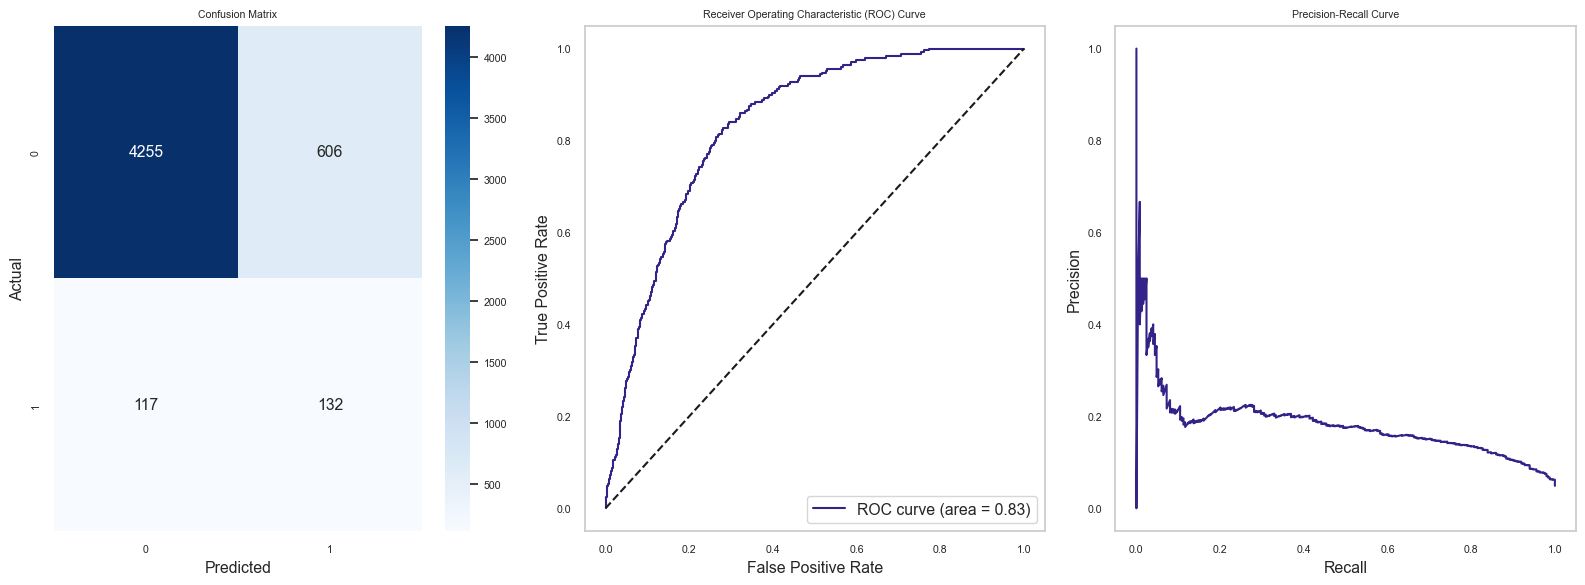

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=cv,
    scoring=scorer,
    n_jobs=2,
    random_state=RANDOM_STATE
)

grid_search_xgb.fit(X_imputed, y)
best_model = grid_search_xgb.best_estimator_
y_pred = cross_val_predict(best_model, X_imputed, y, cv=cv)
y_pred_proba = cross_val_predict(best_model, X_imputed, y, cv=cv, method='predict_proba')[:, 1]

print(f"Best parameters for XGB: {grid_search_xgb.best_params_}")
print(classification_report(y, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba), 6))
visualize_performance(y, y_pred, y_pred_proba)

Best parameters for XGB: {'preprocessor__num__scaler': RobustScaler(), 'model__subsample': 1.0, 'model__scale_pos_weight': 1, 'model__reg_lambda': 0.1, 'model__reg_alpha': 10, 'model__n_estimators': 500, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__colsample_bytree': 0.7, 'model__class_weight': 'balanced', 'feature_selection__estimator__warm_start': False, 'feature_selection__estimator__n_estimators': 150, 'feature_selection__estimator__criterion': 'gini', 'feature_selection__estimator__bootstrap': False}

## Model Ensembling
We created three decent models with the following characteristics:
* **Logistic Regression** - minimize false negatives
* **Random Forest & XGB Classifiers** - minimize false positives with as little impact to false negatives

We will now try to combine these three models into one meta-model using stacking classifier.

In [72]:
from sklearn.ensemble import StackingClassifier

best_params_lr = grid_search_lr.best_params_
best_params_rf = grid_search_rf.best_params_
best_params_xgb = grid_search_xgb.best_params_

best_lr_model = ImbPipeline([
    ('preprocessor', preprocessor_lr),
    ('resampler', resampler_lr),
    ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))),
    ('model', LogisticRegression(random_state=RANDOM_STATE, **{k.split('__')[-1]: v for k, v in best_params_lr.items() if k.startswith('model__')}))
])

best_rf_model = ImbPipeline([
    ('preprocessor', preprocessor_rf),
    ('resampler', resampler_rf),
    ('feature_selection', SelectFromModel(BalancedRandomForestClassifier(random_state=RANDOM_STATE, replacement=True, bootstrap=True))),
    ('model', BalancedRandomForestClassifier(random_state=RANDOM_STATE, **{k.split('__')[-1]: v for k, v in best_params_rf.items() if k.startswith('model__')}))
])

best_xgb_model = ImbPipeline([
    ('preprocessor', preprocessor_xgb),
    ('resampler', resampler_xgb),
    ('feature_selection', SelectFromModel(XGBClassifier(random_state=RANDOM_STATE))),
    ('model', XGBClassifier(random_state=RANDOM_STATE, **{k.split('__')[-1]: v for k, v in best_params_xgb.items() if k.startswith('model__')}))
])

stacking_classifier = StackingClassifier(
    estimators = [
        ('lr', best_lr_model),
        ('rf', best_rf_model),
        ('xgb', best_xgb_model)
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5,
    stack_method='predict_proba'
)

param_grid_stacking = {
    'final_estimator__class_weight': [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}, {0:1, 1:30}, {0:1, 1:40}],
    'final_estimator__C': [0.1, 0.5, 1, 5, 10],
    'xgb__model__learning_rate': [0.01, 0.1],
    'rf__model__n_estimators': [150, 250],
    'lr__model__C': [0.5, 5],
}

Best parameters for Stacking Classifier: {'xgb__model__learning_rate': 0.1, 'rf__model__n_estimators': 150, 'lr__model__C': 5, 'final_estimator__class_weight': {0: 1, 1: 10}, 'final_estimator__C': 1}
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      4861
           1       0.17      0.63      0.27       249

    accuracy                           0.83      5110
   macro avg       0.57      0.74      0.59      5110
weighted avg       0.94      0.83      0.87      5110

ROC-AUC Score: 0.841325


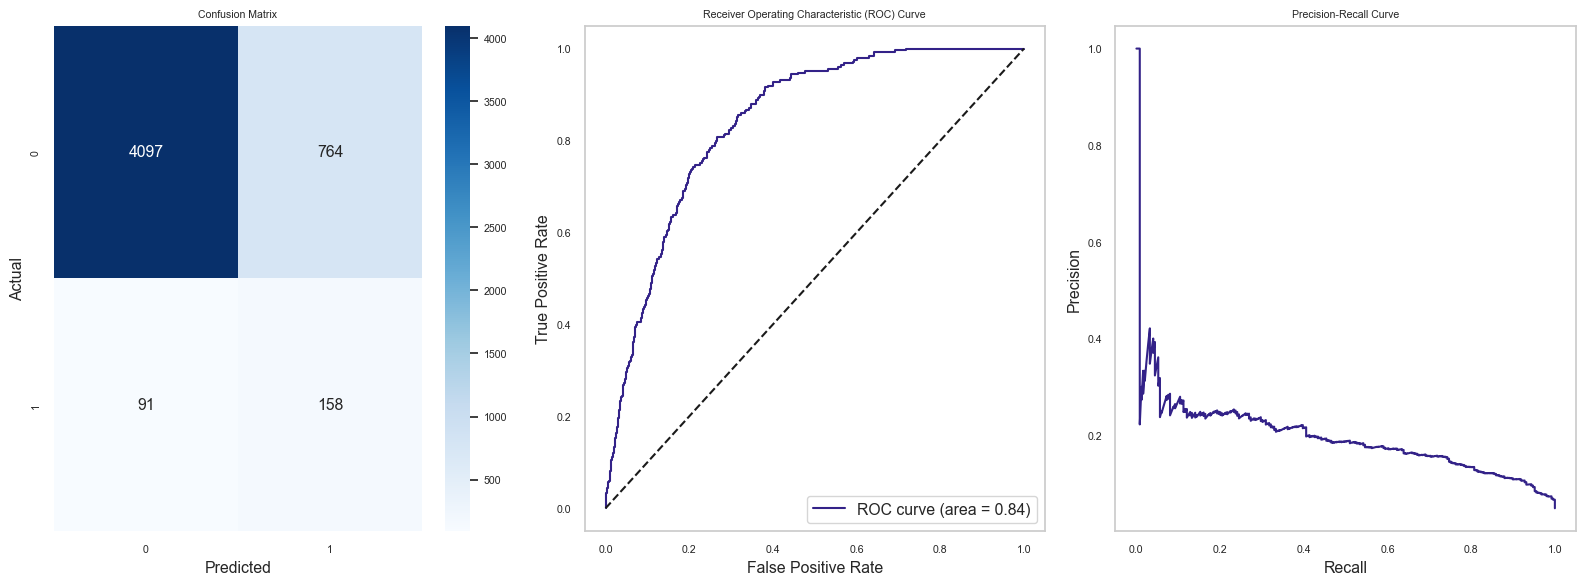

In [73]:
from sklearn.metrics import make_scorer
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, pos_label=1)

grid_search_stacking = RandomizedSearchCV(
    stacking_classifier,
    param_grid_stacking,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_search_stacking.fit(X_imputed, y)
best_model = grid_search_stacking.best_estimator_
y_pred_stacking = cross_val_predict(best_model, X_imputed, y, cv=cv)
y_pred_proba_stacking = cross_val_predict(best_model, X_imputed, y, cv=cv, method='predict_proba')[:, 1]

print(f"Best parameters for Stacking Classifier: {grid_search_stacking.best_params_}")
print(classification_report(y, y_pred_stacking))
print("ROC-AUC Score:", round(roc_auc_score(y, y_pred_proba_stacking), 6))
visualize_performance(y, y_pred_stacking, y_pred_proba_stacking)

Best parameters for Stacking Classifier: {'xgb__model__learning_rate': 0.1, 'rf__model__n_estimators': 150, 'lr__model__C': 5, 'final_estimator__class_weight': {0: 1, 1: 10}, 'final_estimator__C': 1}

## Feature Selection
The next step is to select features that are not redundant. This is especially important for the Logistic Regression model, as it is most susceptible to multicollinearity.
For other models, categorical and continuous representation of the same data may be beneficial and the focus will be to remove least informative features to improve model training speeds.

In [ ]:
#from sklearn.metrics import precision_recall_curve
#precisions, recalls, thresholds = precision_recall_curve(y, y_pred_proba)

The `_log` features have multicollinearity with their original features; Additionally, some newly made features have high correlation with the features they were derived from.

First, let's calculate the feature importances through Random Forest, LightGBM and XGBoost models.

<div class="results">
    <h3>Model Results</h3>
    <p>Feature Transformation & addition - hyperparameter tuning</p>
    <ul>
        <li>Most performance metrics improved, especially positive precision for XGBoost, although the positive recall dropped.</li>
        <li>Positive recall improved for the Random Forest model</li>
    </ul>
</div>

## Kernel Methods Approximation
Let's look for ways to capture non-linear relationships in the data. We will experiment with `Nystroem`.

NOTE: `KernelPCA` is too computationally expensive for our current setup.

In [ ]:
"""
polynomial_param_grid = {
    'polynomial__degree': [1, 2, 3],
    'pca__n_components': [0.85, 0.9, 0.95],
    'model__C': [0.1, 1, 10],
    'model__class_weight': ['balanced', {0:1, 1:5}],
    'model__max_iter': [5000],
}

for model_name, params in param_grids.items():
    if model_name == 'Logistic Regression':
        new_params = {**params, **polynomial_param_grid}
        param_grids[model_name] = new_params
"""

"\npolynomial_param_grid = {\n    'polynomial__degree': [1, 2, 3],\n    'pca__n_components': [0.85, 0.9, 0.95],\n    'model__C': [0.1, 1, 10],\n    'model__class_weight': ['balanced', {0:1, 1:5}],\n    'model__max_iter': [5000],\n}\n\nfor model_name, params in param_grids.items():\n    if model_name == 'Logistic Regression':\n        new_params = {**params, **polynomial_param_grid}\n        param_grids[model_name] = new_params\n"

In [ ]:
"""
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
pipeline.steps.append(('polynomial', PolynomialFeatures(include_bias=False)))
pipeline.steps.append(('scaler_2', StandardScaler()))
pipeline.steps.append(('pca', PCA()))
"""

"\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.decomposition import PCA\npipeline.steps.append(('polynomial', PolynomialFeatures(include_bias=False)))\npipeline.steps.append(('scaler_2', StandardScaler()))\npipeline.steps.append(('pca', PCA()))\n"

## Basic Hyperparameter Tuning
Let's look for the optimal hyperparameters.

In [ ]:
#benchmark_models(preprocessor, param_grids, models, X, y, cv)